In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

In [2]:
def get_res(path, phase, maxiter, subn, lb):
    data_path1 = path%(phase, maxiter, subn, lb)
    print(data_path1)
    data1 = np.load(data_path1)
    return data1['predY0'], data1['std_varY0'], data1['val_predY0'], data1['val_std_varY0'], data1['sample_Y0']

def ucb_strategy(lam, predY0, std_varY0, sample_Y0):
    rt_v = []
    ninvest = 10

    for i in range(len(predY0)):
        p = predY0[i]
        sell_idx = np.argsort(p-lam*std_varY0[i])[:ninvest//2]
        buy_idx = np.argsort(-(p+lam*std_varY0[i]))[:ninvest//2]
        rr = 1/ninvest
        tmp = rr*(sum(exp(sample_Y0[i, buy_idx]))+sum(exp(-sample_Y0[i, sell_idx])))
        rt_v.append(log(tmp))
    return rt_v


def opt_strategy(predY0, std_var_Y0, sample_Y0, cov, delta, cash=1.0):
    rt_v = []
    for i in range(len(predY0)):
        r = exp(predY0[i])
        cov_dia = std_var_Y0[i]**2 * r * r
        cov_current = np.zeros_like(cov)
#         cov_current = cov.copy()
        for k in range(len(r)):
            cov_current[k, k] = cov_dia[k]
        x_opt = solve(len(r), r, cov_current, delta, cash)
#         x_opt = solve2(len(r), r, cov_current, delta)
        
        print(x_opt)
#         print(sum(x_opt))
#         print(sample_Y0[i])
        print(sum(x_opt * exp(sample_Y0[i])))
#         print(predY0[i])
#         print(cov_current[:10, :10])
        
        tmp = sum(x_opt * exp(sample_Y0[i])) / cash
        rt_v.append(log(tmp))
    return rt_v


def max_redraw(rt_v):
    res = max([rt_v[i] - min(rt_v[i+1:]) for i in range(len(rt_v)-1)])
    return res

In [3]:
testv = np.arange(-0.1, 0.10001, 0.01)

In [4]:
def run(path, maxiter, subn, lb, figsize=(10,5), testv=testv, delta=10000):
    rt_lst, rd_lst, naive_lst, opt_lst = [], [], [], []
    for phs in range(4, 12):
#     for phs in range(10, 11):
        print('Phase %d' % phs)
        data_path = './stock_data/stock_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path)
        cov_train, choice = data['cov_train'], data['choice']
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        print('Validating...')
        plt.figure(figsize=figsize)
        _, _, predY0, std_varY0, sample_Y0 = get_res(path, phs, maxiter, subn, lb)

        print('Opt strategy')
        rt_v = opt_strategy(predY0, std_varY0, sample_Y0, cov, delta)
        rd = max_redraw(rt_v)
        print('Opt strategy   Total log return: %.8f    Max redraw: %.8f' % (sum(rt_v), rd))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt = rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i] += exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'r-', label='Opt strategy')

        print('UCB strategy')
        best_logrt = -np.inf
        best_rt_lam = 0
        best_rd = np.inf
        best_rd_lam = 0
        for lam in testv:
            rt_v=ucb_strategy(lam, predY0, std_varY0, sample_Y0)
            rd = max_redraw(rt_v)
            print('lambda: %.3f   Total log return: %.8f    Max redraw: %.8f' % (lam, sum(rt_v), rd))
            if sum(rt_v)>best_logrt:
                best_logrt=sum(rt_v)
                best_rt_lam=lam
            if rd<best_rd:
                best_rd=rd
                best_rd_lam=lam
            exp_rt=rt_v
            for i in range(1, len(rt_v)):
                exp_rt[i]+=exp_rt[i-1]
            exp_rt = exp(exp_rt)
            plt.plot(exp_rt, color='gray', linewidth=0.2)
        rt_v=ucb_strategy(best_rt_lam, predY0, std_varY0, sample_Y0)
        print('best return lambda: %.3f   Total log return: %.8f' % (best_rt_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'b-', label='best return, lambda=%.3f'%best_rt_lam)
        rt_v=ucb_strategy(best_rd_lam, predY0, std_varY0, sample_Y0)
        print('best redraw lambda: %.3f   Total log return: %.8f' % (best_rd_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'g-', label='best redraw, lambda=%.3f'%best_rd_lam)
        rt_v=ucb_strategy(0, predY0, std_varY0, sample_Y0)
        print('Naive lambda: %.3f   Total log return: %.8f' % (0, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'y-', label='Naive, lambda=%.3f'%0)
        plt.title('Validation UCB');    plt.grid();    plt.legend();    plt.show()
        val_best_rt_lam = best_rt_lam
        val_best_rd_lam = best_rd_lam



        print('Testing...')
        plt.figure(figsize=figsize)
        predY0, std_varY0, _, _, sample_Y0 = get_res(path, phs, maxiter, subn, lb)

        print('UCB strategy')
        best_logrt = -np.inf
        best_rt_lam = 0
        best_rd = np.inf
        best_rd_lam = 0

        for lam in testv:
            rt_v=ucb_strategy(lam, predY0, std_varY0, sample_Y0)
            rd = max_redraw(rt_v)
            print('lambda: %.3f   Total log return: %.8f    Max redraw: %.8f' % (lam, sum(rt_v), rd))
            if sum(rt_v)>best_logrt:
                best_logrt=sum(rt_v)
                best_rt_lam=lam
            if rd<best_rd:
                best_rd=rd
                best_rd_lam=lam
            exp_rt=rt_v
            for i in range(1, len(rt_v)):
                exp_rt[i]+=exp_rt[i-1]
            exp_rt = exp(exp_rt)
            plt.plot(exp_rt, color='gray', linewidth=0.2)
        rt_v=ucb_strategy(best_rt_lam, predY0, std_varY0, sample_Y0)
        print('best return lambda: %.3f   Total log return: %.8f' % (best_rt_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'b--', label='best return, lambda=%.3f'%best_rt_lam, linewidth=0.2)
        rt_v=ucb_strategy(best_rd_lam, predY0, std_varY0, sample_Y0)
        print('best redraw lambda: %.3f   Total log return: %.8f' % (best_rd_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'g--', label='best redraw, lambda=%.3f'%best_rd_lam, linewidth=0.2)

        print('------------------------------------------------------------------------------------')

        print('Opt strategy')
        rt_v = opt_strategy(predY0, std_varY0, sample_Y0, cov, delta)
        opt_lst += rt_v.copy()
        print('Opt strategy   Total log return: %.8f    Max redraw: %.8f' % (sum(rt_v), rd))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt = rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i] += exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'r', label='Opt strategy')

        rt_v=ucb_strategy(val_best_rt_lam, predY0, std_varY0, sample_Y0)
        rt_lst += rt_v.copy()
        print('best return val lambda: %.3f   Total log return: %.8f' % (best_rt_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'b', label='best return, val lambda=%.3f'%val_best_rt_lam)
        rt_v=ucb_strategy(best_rd_lam, predY0, std_varY0, sample_Y0)
        rd_lst += rt_v.copy()
        print('best redraw val lambda: %.3f   Total log return: %.8f' % (val_best_rd_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'g', label='best redraw, val lambda=%.3f'%val_best_rd_lam)
        rt_v=ucb_strategy(0, predY0, std_varY0, sample_Y0)
        naive_lst += rt_v.copy()
        print('Naive lambda: %.3f   Total log return: %.8f' % (0, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'y-', label='Naive, lambda=%.3f'%0)
        plt.title('Test UCB');    plt.grid();    plt.legend();    plt.show()
    print('-----------------------------Final result-----------------------------')
    plt.figure(figsize=figsize)
    rt_v = opt_lst
    print('Opt strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt = rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i] += exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'r', label='Opt strategy')

    rt_v=rt_lst
    print('best return strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt=rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i]+=exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'b', label='best return strategy')
    rt_v=rd_lst
    print('best redraw strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt=rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i]+=exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'g', label='best redraw strategy')
    rt_v=naive_lst
    print('Naive strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt=rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i]+=exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'y-', label='Naive strategy')
    plt.title('Overall Test');    plt.grid();    plt.legend();    plt.show()
    
    return opt_lst

In [9]:
lb = 5
maxiter = 8000
subn = 100
path='./tmp2/res_phase%02d_iter%d_subn%d_lb%d.npz'
delta = 0.008

Phase 4
Validating...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
Opt strategy
[0.0045 0.0016 0.     0.002  0.0299 0.008  0.     0.     0.     0.0262
 0.0052 0.0007 0.     0.     0.0135 0.     0.     0.0192 0.     0.
 0.     0.0903 0.     0.     0.     0.0202 0.     0.     0.0001 0.
 0.     0.0091 0.0094 0.     0.0322 0.0096 0.     0.0527 0.     0.
 0.0163 0.     0.0622 0.     0.0461 0.0034 0.0265 0.     0.013  0.1173
 0.0037 0.0169 0.     0.     0.0194 0.     0.     0.     0.     0.
 0.     0.0727 0.0555 0.     0.     0.     0.     0.0102 0.     0.0548
 0.0308 0.     0.003  0.     0.     0.     0.     0.     0.     0.0307
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0044
 0.     0.     0.     0.0297 0.     0.     0.0297 0.     0.     0.0194]
1.0201555124339001
[0.0038 0.     0.     0.     0.0042 0.     0.0263 0.0004 0.     0.
 0.0043 0.     0.     0.     0.     0.     0.     0.0028 0.     0.
 0.0716 0.0143 0.     0.     0.     0.     0.     0.0328 0.0442 0.
 0.   

[0.0022 0.0004 0.     0.0555 0.0443 0.0112 0.     0.     0.     0.0226
 0.     0.     0.     0.     0.0012 0.0045 0.0385 0.0178 0.     0.
 0.     0.0131 0.     0.     0.     0.0095 0.     0.0066 0.0166 0.017
 0.0182 0.0124 0.     0.     0.0716 0.0001 0.     0.013  0.     0.
 0.0855 0.     0.0247 0.     0.     0.     0.     0.     0.0228 0.
 0.     0.0196 0.     0.     0.0086 0.     0.     0.     0.0235 0.
 0.     0.0728 0.0296 0.     0.     0.0368 0.     0.     0.0505 0.0357
 0.0203 0.     0.0556 0.     0.     0.     0.     0.     0.     0.07
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0442 0.     0.     0.     0.     0.     0.0236]
0.9972164682965831
[0.0024 0.     0.     0.0322 0.0271 0.0078 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0012 0.0384 0.     0.
 0.     0.0478 0.     0.     0.027  0.0405 0.0382 0.048  0.0152 0.
 0.     0.     0.0076 0.0344 0.0208 0.0189 0.     0.0121 0.0662 0.
 0.     0.     0.0214 0.0

[0.0027 0.     0.     0.     0.0423 0.     0.     0.0042 0.003  0.0119
 0.     0.     0.     0.0111 0.0117 0.     0.     0.0079 0.     0.
 0.     0.0156 0.     0.     0.0626 0.0267 0.     0.     0.0164 0.0402
 0.0017 0.     0.0024 0.0006 0.0519 0.0042 0.     0.0342 0.     0.
 0.     0.     0.0235 0.     0.     0.     0.0122 0.     0.0284 0.0975
 0.     0.0799 0.     0.     0.0146 0.     0.     0.     0.     0.
 0.0144 0.1263 0.0062 0.     0.     0.0641 0.     0.     0.     0.0253
 0.0152 0.     0.     0.     0.     0.     0.     0.     0.     0.0197
 0.     0.     0.     0.0156 0.     0.     0.     0.     0.     0.0287
 0.015  0.     0.     0.0323 0.     0.     0.0298 0.     0.     0.    ]
1.0101321636878162
[0.005  0.0014 0.     0.     0.0104 0.     0.     0.     0.     0.0008
 0.     0.0028 0.     0.     0.0087 0.     0.     0.0136 0.     0.0281
 0.0164 0.0356 0.     0.     0.005  0.015  0.     0.014  0.0243 0.
 0.     0.     0.0104 0.     0.1099 0.0016 0.     0.0255 0.     0.
 0.   

[0.0037 0.0019 0.     0.     0.0585 0.0179 0.     0.0254 0.     0.0122
 0.0027 0.     0.     0.     0.0306 0.0096 0.0077 0.022  0.     0.
 0.     0.0732 0.     0.     0.     0.0141 0.     0.0355 0.0006 0.0296
 0.0102 0.     0.0118 0.     0.     0.0038 0.0015 0.0324 0.     0.
 0.     0.     0.0072 0.0072 0.0169 0.008  0.0769 0.     0.     0.
 0.0116 0.0575 0.     0.0204 0.011  0.     0.     0.0043 0.     0.
 0.     0.0712 0.     0.0011 0.     0.     0.     0.     0.     0.0329
 0.0346 0.     0.0099 0.     0.     0.     0.0486 0.     0.     0.0007
 0.     0.     0.0066 0.0119 0.     0.     0.     0.     0.0097 0.
 0.     0.     0.     0.0184 0.     0.     0.0907 0.0201 0.     0.0179]
0.9919752620754774
[0.0032 0.     0.     0.     0.     0.0017 0.     0.     0.     0.0195
 0.     0.     0.     0.     0.0218 0.     0.     0.     0.0201 0.
 0.0101 0.0809 0.038  0.     0.0039 0.     0.0704 0.     0.0094 0.
 0.     0.     0.0097 0.0542 0.     0.     0.     0.0324 0.0554 0.
 0.     0.     0.0

[0.0028 0.     0.     0.     0.     0.     0.     0.     0.0162 0.0023
 0.     0.     0.     0.0008 0.     0.     0.     0.027  0.     0.025
 0.0101 0.069  0.     0.     0.0357 0.0361 0.     0.     0.     0.
 0.0215 0.     0.0059 0.0013 0.     0.0072 0.     0.0229 0.059  0.
 0.0238 0.     0.0213 0.0298 0.     0.     0.     0.     0.     0.1433
 0.0165 0.0193 0.     0.0409 0.0491 0.     0.     0.     0.     0.
 0.     0.0543 0.0067 0.0222 0.     0.0169 0.     0.     0.0292 0.
 0.0162 0.     0.     0.     0.     0.     0.     0.     0.     0.0348
 0.     0.     0.0028 0.0148 0.     0.     0.     0.     0.     0.
 0.     0.0005 0.     0.0853 0.0069 0.     0.     0.0225 0.     0.    ]
1.002395979676763
[0.0021 0.     0.     0.     0.0251 0.0139 0.0139 0.     0.     0.
 0.0039 0.     0.     0.     0.     0.     0.     0.014  0.     0.0002
 0.031  0.0627 0.     0.     0.     0.0244 0.     0.     0.0001 0.
 0.0283 0.0124 0.     0.0466 0.0304 0.0086 0.     0.0304 0.0339 0.025
 0.     0.     0.

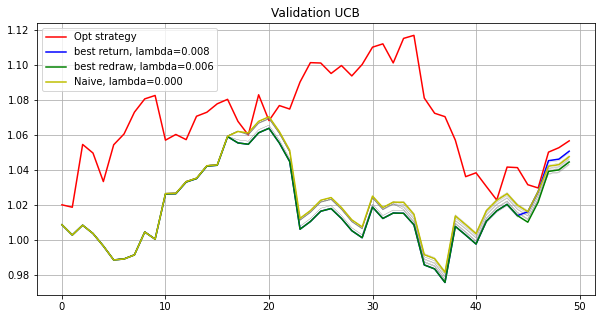

Testing...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.01449593    Max redraw: 0.04741015
lambda: -0.018   Total log return: 0.01716019    Max redraw: 0.04741015
lambda: -0.016   Total log return: 0.02061541    Max redraw: 0.04741015
lambda: -0.014   Total log return: 0.02000184    Max redraw: 0.04741015
lambda: -0.012   Total log return: 0.01634502    Max redraw: 0.04741015
lambda: -0.010   Total log return: 0.01472589    Max redraw: 0.04741015
lambda: -0.008   Total log return: 0.01082606    Max redraw: 0.04741015
lambda: -0.006   Total log return: 0.01604362    Max redraw: 0.04741015
lambda: -0.004   Total log return: 0.02503168    Max redraw: 0.04741015
lambda: -0.002   Total log return: 0.03747112    Max redraw: 0.04741015
lambda: -0.000   Total log return: 0.03954515    Max redraw: 0.04741015
lambda: 0.002   Total log return: 0.04020998    Max redraw: 0.04741015
lambda: 0.004   Total log return: 0.03820739    Max redraw: 0.0474101

[0.     0.     0.     0.     0.0111 0.0207 0.0252 0.     0.     0.
 0.002  0.016  0.     0.0213 0.0031 0.     0.     0.066  0.     0.
 0.     0.     0.     0.     0.     0.0238 0.     0.0011 0.     0.
 0.     0.0342 0.     0.     0.0033 0.0101 0.     0.0331 0.0679 0.0392
 0.     0.     0.0017 0.0176 0.0087 0.0597 0.0691 0.0059 0.0294 0.
 0.0006 0.0176 0.     0.     0.0298 0.0275 0.     0.0156 0.     0.
 0.     0.101  0.     0.0383 0.     0.0639 0.     0.     0.     0.025
 0.0257 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0171 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0454 0.     0.     0.0224 0.     0.     0.    ]
0.9787994773389423
[0.0013 0.     0.     0.     0.     0.0253 0.     0.     0.0044 0.
 0.     0.     0.     0.     0.0229 0.     0.     0.072  0.     0.
 0.     0.     0.0081 0.     0.     0.0084 0.     0.0535 0.0062 0.
 0.     0.0408 0.0016 0.0761 0.     0.007  0.     0.0511 0.0828 0.
 0.0104 0.     0.     0.025  0.

[0.0018 0.     0.     0.     0.0134 0.0139 0.0044 0.0088 0.     0.0086
 0.0015 0.     0.     0.     0.061  0.     0.     0.0008 0.     0.
 0.0292 0.0554 0.     0.     0.     0.0493 0.     0.0129 0.0144 0.0237
 0.084  0.0316 0.0098 0.     0.     0.0286 0.     0.0272 0.0262 0.
 0.     0.     0.     0.     0.     0.0056 0.0008 0.     0.0003 0.0443
 0.0181 0.1294 0.     0.     0.0459 0.     0.     0.0174 0.     0.0455
 0.     0.0127 0.     0.0635 0.     0.0126 0.     0.     0.     0.0318
 0.0125 0.     0.     0.     0.     0.     0.0481 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0052 0.     0.     0.    ]
0.9995726687318521
[0.0032 0.     0.     0.     0.     0.     0.0083 0.     0.     0.
 0.0016 0.     0.     0.0251 0.     0.     0.     0.0109 0.     0.0482
 0.0164 0.0523 0.     0.     0.     0.0492 0.     0.021  0.     0.0344
 0.     0.0629 0.     0.06   0.0044 0.0182 0.     0.0051 0.0817 0.
 0.     0.

[0.0009 0.     0.     0.     0.0197 0.0003 0.0161 0.     0.     0.0082
 0.0059 0.     0.     0.     0.043  0.     0.0282 0.0185 0.     0.0357
 0.039  0.0126 0.0264 0.     0.     0.     0.     0.     0.     0.
 0.     0.0115 0.0038 0.     0.     0.0018 0.     0.0337 0.0486 0.0777
 0.     0.     0.0485 0.     0.024  0.     0.     0.     0.0027 0.
 0.0011 0.0589 0.     0.     0.0174 0.     0.     0.     0.0031 0.
 0.     0.0665 0.04   0.     0.     0.0042 0.     0.     0.1252 0.
 0.0225 0.     0.     0.0008 0.     0.     0.0191 0.     0.     0.0207
 0.     0.     0.005  0.0115 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0154 0.     0.     0.037  0.0168 0.     0.0279]
1.006369292414332
[0.0021 0.0017 0.     0.     0.0182 0.0066 0.0107 0.     0.006  0.0125
 0.0022 0.0001 0.     0.     0.0083 0.     0.0376 0.0094 0.     0.009
 0.0312 0.0521 0.0118 0.     0.0048 0.0311 0.     0.     0.0279 0.
 0.0354 0.0009 0.0097 0.024  0.     0.0159 0.     0.0201 0.     0.
 0.     0.     0

[0.0034 0.     0.     0.     0.     0.0047 0.     0.     0.     0.
 0.0004 0.0052 0.     0.     0.0513 0.     0.     0.0431 0.     0.
 0.     0.     0.     0.     0.     0.0218 0.0192 0.0333 0.0309 0.
 0.029  0.0047 0.     0.0542 0.     0.0262 0.     0.0019 0.0412 0.
 0.0961 0.     0.     0.0056 0.     0.     0.0888 0.     0.     0.
 0.     0.0565 0.031  0.     0.0367 0.0009 0.     0.     0.     0.
 0.     0.0554 0.     0.     0.     0.0671 0.     0.     0.0501 0.
 0.0048 0.     0.     0.     0.     0.     0.     0.     0.     0.046
 0.0208 0.     0.     0.0123 0.0172 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0402 0.     0.     0.    ]
0.9951710629229277
[0.0008 0.     0.     0.0257 0.     0.     0.     0.0125 0.0082 0.0052
 0.     0.     0.     0.     0.0091 0.     0.     0.0308 0.     0.
 0.0222 0.0438 0.     0.     0.0128 0.0147 0.0158 0.0823 0.0176 0.
 0.     0.073  0.0107 0.0643 0.     0.     0.     0.0077 0.0165 0.0388
 0.0057 0.     0.0094 0.   

[0.0005 0.     0.     0.     0.     0.0059 0.0046 0.     0.     0.
 0.0007 0.0033 0.     0.     0.     0.     0.     0.06   0.     0.0057
 0.0163 0.1133 0.0022 0.     0.     0.0181 0.     0.     0.0194 0.
 0.     0.0243 0.0112 0.0203 0.027  0.     0.     0.0376 0.     0.
 0.     0.     0.014  0.     0.     0.     0.     0.0452 0.0041 0.0373
 0.0105 0.0283 0.     0.     0.0103 0.0143 0.     0.021  0.     0.
 0.0368 0.     0.     0.0381 0.     0.1055 0.     0.     0.0646 0.
 0.0269 0.     0.     0.     0.     0.     0.0422 0.     0.     0.0001
 0.0793 0.     0.0325 0.0088 0.     0.     0.     0.0057 0.     0.
 0.     0.0042 0.     0.     0.     0.     0.     0.     0.     0.    ]
1.001831716647897
[0.0031 0.     0.     0.     0.0352 0.0141 0.     0.     0.0027 0.0281
 0.     0.0174 0.     0.     0.     0.     0.     0.0655 0.     0.
 0.0555 0.0504 0.0051 0.     0.     0.0198 0.     0.0184 0.0179 0.
 0.0058 0.0061 0.0075 0.0428 0.     0.     0.     0.0632 0.0002 0.
 0.028  0.     0.     0

[0.0006 0.     0.     0.0484 0.0093 0.0037 0.0147 0.0189 0.     0.0201
 0.     0.     0.     0.     0.     0.     0.0463 0.0471 0.     0.
 0.     0.0437 0.     0.     0.0072 0.0377 0.032  0.0158 0.0156 0.
 0.     0.0368 0.     0.0222 0.0207 0.001  0.     0.0266 0.0591 0.
 0.     0.     0.0412 0.     0.     0.     0.     0.     0.     0.0298
 0.     0.0128 0.     0.     0.0235 0.0125 0.     0.     0.0201 0.0165
 0.     0.067  0.     0.     0.     0.     0.     0.     0.1513 0.
 0.0059 0.     0.     0.     0.     0.     0.0136 0.     0.     0.0498
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0285]
1.0086531470650595
[0.     0.     0.     0.     0.0024 0.006  0.     0.     0.     0.
 0.0014 0.0042 0.     0.0037 0.     0.     0.0584 0.0047 0.     0.
 0.0432 0.047  0.0206 0.     0.006  0.0435 0.     0.0158 0.     0.
 0.     0.0647 0.     0.0584 0.     0.0016 0.     0.0367 0.0161 0.
 0.0744 0.     0.     

[0.0029 0.     0.     0.     0.     0.0099 0.     0.     0.0039 0.0215
 0.     0.     0.     0.     0.0151 0.     0.0011 0.0523 0.     0.029
 0.     0.     0.     0.     0.     0.0094 0.     0.1317 0.0248 0.
 0.0005 0.     0.     0.0332 0.0018 0.0204 0.     0.0323 0.0141 0.
 0.     0.     0.0061 0.     0.0408 0.     0.     0.     0.0016 0.0409
 0.     0.0458 0.0183 0.     0.0376 0.     0.     0.     0.     0.
 0.     0.0742 0.     0.0005 0.     0.0613 0.0293 0.     0.     0.
 0.0099 0.     0.017  0.     0.     0.     0.     0.     0.     0.1138
 0.0442 0.     0.0159 0.     0.0252 0.     0.     0.     0.0004 0.
 0.     0.0028 0.     0.     0.     0.     0.0037 0.     0.     0.0067]
1.0034395089657553
[0.0027 0.0007 0.     0.     0.     0.0095 0.0182 0.0191 0.     0.
 0.     0.0077 0.     0.     0.047  0.     0.     0.027  0.     0.
 0.     0.0499 0.     0.     0.     0.0004 0.     0.0129 0.     0.
 0.     0.0207 0.0034 0.0414 0.     0.011  0.     0.0222 0.005  0.0152
 0.0108 0.     0.00

[0.0002 0.     0.     0.013  0.     0.     0.     0.     0.0016 0.0169
 0.     0.     0.     0.     0.     0.     0.     0.0579 0.     0.
 0.     0.     0.0071 0.0004 0.     0.0234 0.0338 0.     0.0236 0.
 0.     0.     0.0061 0.0907 0.0002 0.0117 0.     0.0534 0.0593 0.
 0.     0.     0.0723 0.0016 0.     0.     0.     0.     0.     0.0415
 0.0023 0.0209 0.     0.     0.0163 0.0591 0.     0.     0.0621 0.
 0.     0.0633 0.     0.     0.     0.073  0.0091 0.     0.     0.
 0.     0.     0.     0.     0.     0.0591 0.     0.0891 0.     0.0113
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0197 0.     0.     0.    ]
1.0068585376797474
[0.0027 0.     0.     0.     0.0345 0.0195 0.     0.035  0.     0.0459
 0.     0.0243 0.     0.     0.     0.     0.     0.0484 0.     0.
 0.     0.     0.0169 0.     0.0122 0.0397 0.     0.0028 0.     0.0366
 0.     0.     0.0097 0.0678 0.     0.0235 0.     0.021  0.     0.0076
 0.     0.    

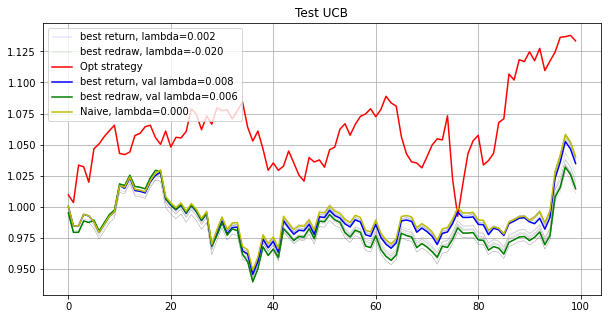

Phase 5
Validating...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.0074 0.0137 0.     0.     0.0077 0.004  0.0128 0.     0.0021
 0.     0.     0.     0.0055 0.0221 0.0294 0.0036 0.0013 0.0127 0.
 0.0424 0.0119 0.0078 0.0267 0.0283 0.     0.     0.0156 0.     0.
 0.     0.0331 0.     0.     0.     0.     0.     0.     0.0345 0.
 0.     0.     0.     0.     0.     0.     0.0051 0.     0.0092 0.0061
 0.     0.     0.0837 0.0349 0.     0.     0.     0.0383 0.     0.0134
 0.028  0.     0.     0.0327 0.078  0.0077 0.     0.     0.0471 0.
 0.     0.015  0.0365 0.     0.     0.     0.     0.06   0.04   0.
 0.0243 0.0143 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0281 0.021  0.     0.     0.     0.     0.0088 0.     0.0453]
0.9887178922351189
[0.     0.0087 0.0318 0.     0.     0.     0.0079 0.     0.     0.0049
 0.     0.     0.0012 0.     0.0356 0.0129 0.     0.0087 0.0435 0.
 0.0184 0.     0.0084 0.0434 0.0057 0.0177 0.0317 0.     0.0113 0.
 0.0017 0.

[0.     0.0108 0.0137 0.0025 0.     0.015  0.0073 0.0065 0.0315 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0071 0.
 0.0127 0.0161 0.0127 0.0072 0.     0.     0.     0.     0.     0.
 0.     0.     0.042  0.0191 0.0297 0.     0.     0.     0.0283 0.
 0.0322 0.0121 0.     0.     0.     0.0011 0.0403 0.0261 0.     0.
 0.     0.     0.0063 0.0474 0.     0.     0.     0.0414 0.0035 0.0134
 0.     0.     0.     0.0069 0.0672 0.     0.     0.0409 0.0386 0.
 0.0057 0.     0.     0.0691 0.     0.     0.0066 0.0051 0.0177 0.
 0.0154 0.     0.     0.0465 0.0434 0.0025 0.0061 0.     0.     0.
 0.     0.     0.0215 0.0118 0.0332 0.     0.     0.0088 0.0225 0.0446]
1.0004249111232706
[0.0143 0.0094 0.0208 0.     0.     0.     0.     0.0097 0.0047 0.
 0.     0.     0.     0.0031 0.0368 0.0677 0.     0.     0.019  0.
 0.0246 0.0236 0.0126 0.     0.0119 0.     0.0482 0.     0.     0.0007
 0.     0.     0.0415 0.0376 0.     0.     0.     0.     0.     0.
 0.     0.0191 0.     0.0044 0

[0.     0.0097 0.0076 0.     0.     0.0087 0.007  0.0165 0.0737 0.
 0.     0.     0.     0.     0.046  0.0103 0.     0.     0.0073 0.
 0.0196 0.0155 0.0146 0.0257 0.0103 0.     0.     0.     0.     0.
 0.0288 0.     0.0105 0.0093 0.0239 0.0267 0.0192 0.     0.     0.0154
 0.     0.0104 0.     0.0011 0.     0.     0.     0.0322 0.0077 0.
 0.     0.     0.0597 0.053  0.     0.     0.0017 0.     0.0402 0.0136
 0.0288 0.     0.0028 0.0174 0.0116 0.     0.0141 0.0207 0.0206 0.
 0.     0.     0.     0.     0.     0.     0.0027 0.025  0.0438 0.0369
 0.     0.     0.     0.0559 0.0285 0.     0.0055 0.     0.     0.
 0.     0.     0.0243 0.     0.0083 0.     0.     0.0014 0.     0.0256]
1.0023958121775318
[0.     0.0107 0.0018 0.0308 0.     0.0086 0.0061 0.0055 0.     0.
 0.     0.     0.0017 0.0109 0.0088 0.     0.     0.     0.     0.
 0.0207 0.0051 0.0161 0.     0.0092 0.     0.     0.0275 0.     0.
 0.     0.     0.0116 0.     0.     0.0022 0.0003 0.     0.0404 0.0179
 0.0501 0.0334 0.     

[0.0137 0.0097 0.0416 0.     0.     0.0015 0.0009 0.0129 0.     0.0036
 0.     0.     0.0099 0.003  0.     0.0174 0.0067 0.0394 0.     0.
 0.0226 0.0103 0.0087 0.013  0.     0.     0.     0.0373 0.     0.0391
 0.0105 0.     0.0138 0.0481 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0164 0.     0.     0.     0.     0.0021 0.0223
 0.     0.     0.0644 0.0428 0.     0.     0.     0.     0.     0.0376
 0.028  0.     0.     0.0655 0.0736 0.0089 0.     0.     0.0273 0.
 0.     0.0266 0.     0.     0.     0.     0.0016 0.0427 0.032  0.
 0.0198 0.     0.0032 0.0236 0.     0.     0.     0.0017 0.     0.
 0.     0.019  0.0245 0.     0.     0.0171 0.0144 0.021  0.     0.    ]
1.0225897188259707
[0.     0.0108 0.0352 0.0187 0.     0.     0.0031 0.0128 0.0228 0.
 0.     0.     0.     0.     0.0466 0.0126 0.     0.     0.0224 0.
 0.0193 0.0012 0.0186 0.     0.     0.     0.     0.0363 0.     0.
 0.     0.     0.0093 0.03   0.     0.0122 0.     0.     0.0325 0.
 0.0001 0.023  0.0028 

[0.     0.0096 0.     0.     0.     0.     0.0078 0.     0.     0.0013
 0.     0.     0.0026 0.     0.0122 0.     0.     0.007  0.     0.
 0.0341 0.     0.0058 0.     0.     0.0203 0.     0.0146 0.     0.
 0.     0.014  0.0108 0.0209 0.0218 0.0377 0.     0.0182 0.0836 0.
 0.0088 0.     0.     0.     0.     0.0193 0.0099 0.     0.0091 0.0282
 0.     0.0038 0.0688 0.0355 0.     0.     0.     0.0326 0.     0.0113
 0.021  0.0152 0.     0.0311 0.0167 0.     0.0185 0.0312 0.0262 0.
 0.0026 0.0275 0.     0.     0.     0.     0.     0.0719 0.0344 0.
 0.     0.0008 0.0195 0.026  0.0594 0.     0.     0.     0.     0.
 0.     0.     0.0185 0.     0.0128 0.     0.     0.0161 0.     0.0007]
0.9901658038868998
[0.     0.0097 0.0047 0.     0.     0.009  0.0075 0.0127 0.     0.
 0.     0.     0.     0.     0.026  0.0137 0.     0.     0.     0.
 0.0195 0.0103 0.0144 0.028  0.0179 0.     0.     0.     0.     0.0468
 0.     0.0213 0.0155 0.0036 0.0132 0.     0.     0.     0.0925 0.
 0.0178 0.0036 0.003  

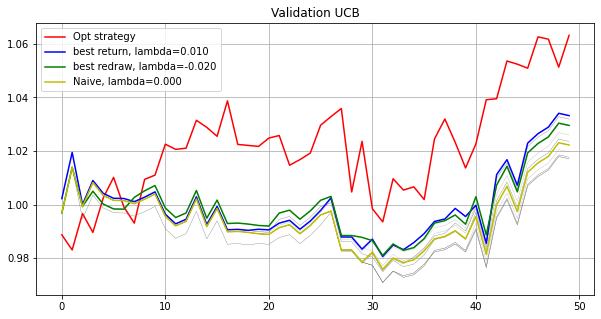

Testing...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09457053    Max redraw: 0.05127117
lambda: -0.018   Total log return: 0.09657663    Max redraw: 0.05127117
lambda: -0.016   Total log return: 0.07670235    Max redraw: 0.05127117
lambda: -0.014   Total log return: 0.06304404    Max redraw: 0.05127117
lambda: -0.012   Total log return: 0.06297960    Max redraw: 0.05127117
lambda: -0.010   Total log return: 0.07044942    Max redraw: 0.05127117
lambda: -0.008   Total log return: 0.07622245    Max redraw: 0.05127117
lambda: -0.006   Total log return: 0.07791816    Max redraw: 0.05127117
lambda: -0.004   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.002   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.000   Total log return: 0.06776157    Max redraw: 0.05129385
lambda: 0.002   Total log return: 0.07697366    Max redraw: 0.05129385
lambda: 0.004   Total log return: 0.07856000    Max redraw: 0.0497349

[0.0035 0.01   0.     0.     0.     0.0152 0.0066 0.0003 0.     0.001
 0.     0.     0.0059 0.0051 0.0478 0.0199 0.     0.0137 0.0077 0.
 0.0066 0.0295 0.0107 0.0254 0.0011 0.     0.     0.0086 0.     0.0414
 0.     0.     0.     0.0155 0.0024 0.     0.     0.     0.     0.
 0.0458 0.0319 0.     0.0211 0.     0.0013 0.     0.0241 0.0601 0.
 0.     0.     0.0611 0.0577 0.     0.     0.     0.     0.     0.
 0.0169 0.     0.     0.     0.     0.     0.0096 0.0542 0.042  0.
 0.     0.0427 0.     0.     0.     0.     0.     0.0896 0.024  0.
 0.     0.     0.     0.064  0.0264 0.0047 0.     0.     0.     0.
 0.     0.     0.0216 0.     0.0197 0.     0.     0.0034 0.     0.    ]
1.0119252246765134
[0.     0.0094 0.0101 0.0005 0.     0.0128 0.0053 0.0143 0.0646 0.0059
 0.     0.     0.     0.0107 0.0442 0.0103 0.     0.0157 0.0038 0.
 0.0068 0.0068 0.0117 0.0255 0.0215 0.     0.     0.     0.     0.0286
 0.     0.     0.0281 0.0774 0.     0.0515 0.     0.     0.     0.0106
 0.0055 0.0073 0.  

[0.     0.0096 0.0233 0.     0.     0.     0.0106 0.0173 0.0174 0.0034
 0.     0.     0.     0.     0.0238 0.     0.014  0.0296 0.0169 0.
 0.0253 0.0195 0.0133 0.0207 0.0037 0.0134 0.0013 0.0196 0.     0.0044
 0.     0.     0.     0.0201 0.0236 0.0266 0.     0.     0.0138 0.
 0.     0.0192 0.     0.008  0.     0.     0.     0.0216 0.     0.
 0.     0.     0.0353 0.002  0.     0.     0.     0.0156 0.     0.0263
 0.0304 0.     0.0042 0.0131 0.0669 0.0019 0.     0.     0.022  0.
 0.     0.     0.     0.0065 0.     0.     0.     0.0139 0.0172 0.0893
 0.0162 0.     0.036  0.0439 0.0251 0.     0.     0.     0.     0.
 0.0842 0.     0.0176 0.     0.0032 0.     0.     0.0091 0.     0.    ]
0.9940540829492943
[0.0045 0.0073 0.     0.     0.     0.0265 0.0066 0.0117 0.0176 0.
 0.     0.     0.003  0.     0.0257 0.0121 0.     0.     0.0536 0.
 0.0516 0.     0.0086 0.0247 0.     0.0331 0.     0.0125 0.     0.0417
 0.     0.     0.     0.     0.     0.0134 0.     0.     0.     0.
 0.     0.0436 0. 

[0.     0.0075 0.     0.     0.     0.022  0.006  0.021  0.0193 0.
 0.     0.     0.     0.0047 0.0643 0.0056 0.     0.     0.0162 0.
 0.0122 0.0215 0.0035 0.002  0.0023 0.0011 0.     0.     0.     0.0595
 0.     0.0102 0.0169 0.0078 0.0118 0.0156 0.0028 0.     0.     0.
 0.     0.0069 0.     0.     0.     0.     0.0168 0.0393 0.0171 0.0198
 0.0319 0.     0.0532 0.0391 0.     0.0056 0.     0.     0.     0.
 0.0313 0.     0.     0.     0.0281 0.     0.     0.     0.0118 0.
 0.     0.     0.0733 0.     0.     0.     0.     0.0739 0.0336 0.
 0.     0.0156 0.     0.0674 0.0297 0.     0.     0.     0.     0.
 0.     0.     0.0114 0.0444 0.0157 0.     0.     0.     0.     0.    ]
1.0024976734193662
[0.013  0.0096 0.0304 0.0061 0.     0.     0.0104 0.0097 0.0113 0.0101
 0.     0.     0.0037 0.     0.0307 0.     0.0884 0.     0.0219 0.
 0.0299 0.0122 0.0162 0.     0.     0.005  0.     0.0175 0.0043 0.0187
 0.     0.0588 0.     0.     0.     0.0211 0.     0.     0.     0.
 0.0114 0.     0.0056 

[0.     0.0087 0.0109 0.     0.     0.0215 0.0073 0.0138 0.     0.
 0.     0.     0.0026 0.     0.0384 0.0501 0.0441 0.     0.0152 0.
 0.0279 0.038  0.0143 0.0044 0.0049 0.     0.     0.0196 0.     0.
 0.     0.0077 0.     0.     0.0066 0.0432 0.     0.     0.0203 0.0059
 0.0077 0.0385 0.     0.004  0.     0.     0.0016 0.028  0.0367 0.
 0.     0.     0.0119 0.0331 0.     0.     0.     0.     0.     0.0081
 0.0026 0.0175 0.0155 0.0056 0.0489 0.0103 0.     0.0018 0.0204 0.
 0.     0.0129 0.056  0.0058 0.     0.     0.     0.0591 0.0309 0.0334
 0.0311 0.     0.     0.0063 0.0063 0.     0.     0.     0.0008 0.
 0.     0.     0.0161 0.     0.     0.     0.0004 0.0048 0.     0.0385]
1.0083481112656407
[0.0185 0.0108 0.0112 0.0093 0.     0.0118 0.0087 0.0057 0.01   0.0023
 0.     0.     0.     0.     0.0069 0.     0.     0.03   0.0233 0.
 0.0194 0.     0.0186 0.     0.0192 0.     0.     0.0347 0.0029 0.0003
 0.     0.0092 0.0081 0.0058 0.     0.0395 0.     0.0041 0.0078 0.
 0.0471 0.0385 0. 

[0.0059 0.0103 0.0055 0.     0.     0.0083 0.0092 0.0191 0.     0.002
 0.     0.     0.0032 0.0042 0.     0.0001 0.     0.0148 0.     0.
 0.0208 0.     0.0124 0.     0.0362 0.0361 0.     0.     0.     0.
 0.     0.     0.     0.0335 0.0261 0.0222 0.     0.     0.0003 0.
 0.0062 0.0106 0.     0.0029 0.     0.     0.     0.     0.     0.0182
 0.     0.     0.0566 0.0449 0.0162 0.     0.     0.0311 0.     0.0233
 0.0323 0.     0.     0.0182 0.0809 0.0141 0.     0.0165 0.0511 0.
 0.     0.0296 0.     0.0109 0.     0.0103 0.     0.0426 0.007  0.0454
 0.0293 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0273 0.     0.0322 0.0391 0.0085 0.     0.     0.0246 0.     0.    ]
0.9999661865755356
[0.     0.0116 0.0028 0.     0.0018 0.0182 0.0056 0.     0.007  0.
 0.     0.     0.     0.     0.0222 0.     0.     0.0032 0.0024 0.
 0.0428 0.     0.0109 0.0131 0.0019 0.0406 0.     0.     0.     0.
 0.     0.0858 0.0265 0.0336 0.0285 0.     0.     0.0022 0.0021 0.
 0.     0.0079 0.0089 0

[0.     0.0104 0.0052 0.0128 0.     0.0085 0.0074 0.     0.054  0.0072
 0.     0.     0.     0.012  0.     0.0056 0.0013 0.     0.0206 0.
 0.0198 0.0313 0.0164 0.0563 0.0073 0.     0.     0.0245 0.     0.
 0.     0.     0.     0.0115 0.     0.0264 0.0191 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0115 0.     0.     0.
 0.     0.     0.0318 0.0081 0.     0.     0.     0.     0.0415 0.0231
 0.0161 0.     0.     0.0124 0.0692 0.     0.0027 0.0163 0.0272 0.
 0.0064 0.     0.0332 0.0049 0.     0.     0.0157 0.0577 0.0249 0.
 0.     0.004  0.0541 0.0012 0.0403 0.     0.0017 0.     0.0059 0.
 0.0529 0.0124 0.0229 0.     0.0129 0.     0.     0.0315 0.     0.    ]
1.0035224853624478
[0.0044 0.0095 0.0258 0.0077 0.     0.     0.0057 0.0145 0.0665 0.0027
 0.     0.     0.     0.0032 0.0305 0.0039 0.0642 0.     0.0238 0.
 0.0151 0.0194 0.0145 0.0206 0.     0.     0.     0.     0.     0.0166
 0.     0.     0.     0.0362 0.0149 0.0207 0.     0.     0.0023 0.
 0.0298 0.0283 0.     

[0.0015 0.009  0.0167 0.     0.     0.0053 0.0088 0.0115 0.     0.001
 0.     0.     0.     0.0026 0.0266 0.002  0.     0.     0.0185 0.
 0.0196 0.0418 0.0129 0.026  0.     0.     0.     0.     0.     0.011
 0.     0.     0.     0.022  0.0241 0.0502 0.0243 0.     0.0193 0.0696
 0.0081 0.008  0.     0.0079 0.0018 0.     0.0017 0.0047 0.0131 0.
 0.     0.     0.     0.0436 0.     0.     0.     0.0307 0.032  0.0326
 0.0312 0.     0.0126 0.     0.0351 0.     0.     0.     0.0288 0.
 0.     0.0398 0.     0.0156 0.     0.     0.     0.0251 0.0187 0.0912
 0.     0.     0.0144 0.0288 0.0065 0.0022 0.     0.     0.     0.
 0.     0.     0.0246 0.     0.0098 0.     0.     0.     0.     0.0071]
0.9982857233754462
[0.0115 0.0093 0.0041 0.     0.     0.0061 0.0091 0.0079 0.     0.
 0.0143 0.     0.     0.     0.0445 0.0188 0.     0.0292 0.0407 0.
 0.0499 0.     0.0114 0.0041 0.0177 0.     0.     0.0018 0.     0.
 0.0138 0.0087 0.     0.0175 0.0317 0.0052 0.0129 0.0021 0.     0.
 0.0391 0.0218 0.   

[0.0048 0.009  0.     0.     0.     0.0019 0.0037 0.0069 0.0766 0.0004
 0.     0.     0.     0.     0.0309 0.0066 0.     0.     0.0199 0.
 0.0304 0.0082 0.0123 0.0268 0.0043 0.     0.     0.0261 0.0012 0.0194
 0.     0.0007 0.0107 0.0333 0.0103 0.0349 0.     0.     0.0057 0.0457
 0.     0.     0.     0.0112 0.     0.     0.     0.0205 0.0197 0.0114
 0.     0.     0.0312 0.0599 0.     0.     0.     0.     0.0823 0.0321
 0.0352 0.     0.0004 0.0228 0.     0.0124 0.0095 0.0205 0.0172 0.
 0.0014 0.0139 0.     0.0315 0.     0.     0.     0.0103 0.0265 0.
 0.     0.0042 0.     0.0317 0.0136 0.     0.0114 0.     0.     0.
 0.     0.     0.0189 0.     0.0081 0.     0.0066 0.0049 0.     0.    ]
1.0058703405764837
[0.     0.0105 0.0065 0.0116 0.     0.0123 0.0006 0.     0.0114 0.0001
 0.     0.     0.0032 0.001  0.0113 0.0055 0.     0.     0.     0.
 0.013  0.0164 0.0136 0.0268 0.     0.     0.     0.0358 0.     0.0001
 0.     0.     0.0364 0.0258 0.     0.     0.     0.     0.0196 0.
 0.0107 0.

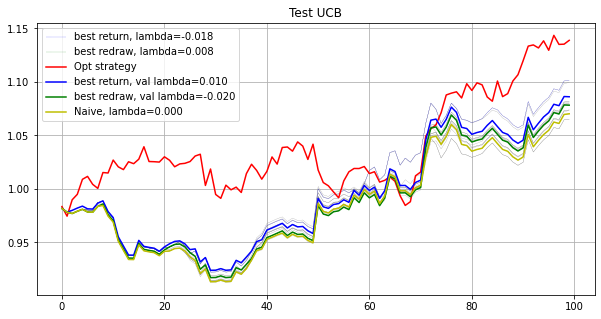

Phase 6
Validating...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.0076 0.0007 0.     0.     0.     0.     0.
 0.     0.013  0.0071 0.     0.     0.     0.0031 0.0005 0.     0.0874
 0.048  0.     0.     0.     0.     0.0098 0.     0.     0.     0.0457
 0.     0.     0.     0.0113 0.     0.0207 0.     0.0234 0.0192 0.
 0.     0.     0.     0.0307 0.     0.     0.0569 0.     0.     0.
 0.     0.     0.     0.0238 0.     0.     0.     0.     0.     0.
 0.     0.031  0.0393 0.0316 0.0448 0.0542 0.     0.0272 0.     0.
 0.     0.0571 0.     0.     0.     0.     0.     0.0846 0.0033 0.0284
 0.     0.     0.     0.     0.     0.0075 0.     0.     0.     0.
 0.     0.015  0.     0.     0.     0.     0.     0.0495 0.064  0.0536]
0.9979112040123184
[0.     0.     0.     0.0018 0.     0.0085 0.     0.0031 0.     0.
 0.0023 0.0071 0.     0.     0.     0.     0.     0.0009 0.0099 0.
 0.     0.021  0.0241 0.     0.0039 0.0494 0.     0.     0.0037 0.054
 0.     0. 

[0.     0.     0.     0.0042 0.0009 0.004  0.     0.     0.     0.
 0.026  0.     0.     0.     0.0228 0.     0.026  0.     0.0445 0.
 0.0338 0.     0.     0.0263 0.     0.     0.     0.     0.     0.063
 0.0362 0.     0.     0.0385 0.     0.     0.0441 0.     0.     0.
 0.005  0.     0.     0.004  0.     0.     0.0286 0.     0.     0.
 0.     0.0241 0.0111 0.     0.     0.     0.     0.0334 0.     0.
 0.     0.005  0.0145 0.0999 0.0354 0.0487 0.     0.     0.0027 0.
 0.     0.0819 0.     0.     0.     0.     0.     0.0586 0.0066 0.0195
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0254 0.     0.     0.     0.0535 0.0719]
1.0025389848251165
[0.     0.0115 0.     0.0001 0.     0.0046 0.     0.     0.     0.
 0.0151 0.     0.     0.     0.     0.     0.     0.     0.0417 0.
 0.0279 0.0009 0.     0.0069 0.     0.0072 0.     0.0194 0.     0.0347
 0.0032 0.     0.     0.     0.     0.     0.0212 0.0101 0.0104 0.0096
 0.0368 0.     0.     0

[0.     0.0106 0.0028 0.0058 0.     0.0077 0.0024 0.0054 0.     0.
 0.     0.0702 0.0012 0.     0.     0.0165 0.0022 0.0043 0.0181 0.0158
 0.0378 0.0349 0.0313 0.0069 0.0058 0.0118 0.     0.     0.0126 0.0535
 0.     0.     0.     0.     0.     0.0316 0.0605 0.0092 0.0035 0.0137
 0.0066 0.0089 0.0099 0.0166 0.0876 0.0259 0.     0.     0.     0.
 0.     0.     0.0061 0.0016 0.     0.0288 0.     0.     0.     0.
 0.     0.0075 0.0089 0.016  0.0355 0.     0.     0.0264 0.0072 0.
 0.004  0.0538 0.0003 0.0165 0.031  0.     0.0173 0.     0.003  0.0048
 0.     0.     0.     0.     0.     0.0222 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0438 0.     0.0336]
0.9944429533233791
[0.     0.019  0.003  0.0074 0.     0.0106 0.0033 0.0077 0.     0.
 0.0106 0.     0.0045 0.     0.0927 0.     0.     0.01   0.0011 0.
 0.0247 0.0038 0.0062 0.     0.0158 0.0168 0.     0.     0.013  0.0331
 0.     0.     0.0021 0.001  0.0231 0.     0.055  0.0367 0.0157 0.008
 0.009  0.     

[0.0031 0.0025 0.0021 0.0043 0.0166 0.0055 0.0021 0.0067 0.     0.
 0.     0.0651 0.0043 0.     0.     0.     0.     0.0063 0.0215 0.0143
 0.032  0.0087 0.0151 0.0087 0.0101 0.     0.0032 0.0381 0.0056 0.0348
 0.     0.0032 0.     0.     0.     0.     0.0048 0.0107 0.0121 0.0069
 0.     0.0062 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0194 0.0215 0.021  0.     0.0061 0.     0.     0.     0.
 0.1048 0.0137 0.0191 0.0124 0.0168 0.0143 0.     0.0398 0.0116 0.
 0.0143 0.0838 0.     0.     0.     0.     0.0038 0.0463 0.0229 0.0302
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0339 0.0031 0.     0.0234 0.     0.0043 0.0773 0.0014]
1.0028864775799324
[0.     0.0038 0.     0.0025 0.     0.0017 0.     0.0012 0.     0.
 0.0198 0.     0.     0.     0.0406 0.     0.     0.     0.047  0.
 0.     0.0146 0.0052 0.     0.     0.0249 0.     0.     0.0032 0.0492
 0.0185 0.0049 0.     0.0068 0.     0.     0.     0.032  0.0138 0.
 0.     0.     0.0

[0.011  0.     0.     0.0029 0.0219 0.0023 0.     0.0027 0.     0.0221
 0.0034 0.0056 0.     0.     0.0175 0.     0.0074 0.     0.0354 0.
 0.0029 0.0133 0.0087 0.0186 0.0005 0.027  0.     0.     0.0042 0.0255
 0.003  0.     0.     0.0111 0.     0.     0.029  0.0331 0.     0.0104
 0.     0.     0.     0.0023 0.     0.     0.     0.     0.     0.
 0.     0.0088 0.     0.0071 0.     0.     0.     0.0085 0.     0.
 0.045  0.0101 0.0049 0.0352 0.001  0.036  0.0091 0.0428 0.0361 0.
 0.     0.045  0.     0.0215 0.     0.     0.     0.0759 0.     0.
 0.     0.     0.     0.0017 0.     0.     0.     0.     0.1309 0.0047
 0.     0.     0.0593 0.     0.     0.     0.     0.     0.0502 0.0445]
1.0030148002272012
[0.     0.     0.     0.0057 0.     0.     0.     0.     0.     0.
 0.     0.0082 0.     0.     0.     0.     0.     0.     0.0408 0.
 0.0325 0.     0.0081 0.     0.     0.0195 0.     0.0513 0.     0.0371
 0.     0.0052 0.     0.     0.     0.     0.0257 0.     0.0082 0.
 0.0123 0.     0. 

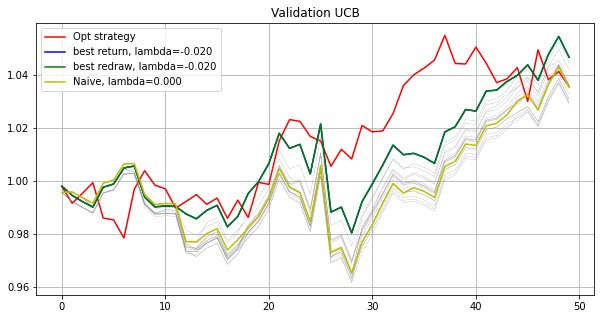

Testing...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.20825661    Max redraw: 0.04421898
lambda: -0.018   Total log return: 0.20924816    Max redraw: 0.04421898
lambda: -0.016   Total log return: 0.21651083    Max redraw: 0.04421898
lambda: -0.014   Total log return: 0.21232723    Max redraw: 0.04421898
lambda: -0.012   Total log return: 0.21022755    Max redraw: 0.04421898
lambda: -0.010   Total log return: 0.20631076    Max redraw: 0.04421898
lambda: -0.008   Total log return: 0.20639946    Max redraw: 0.04421898
lambda: -0.006   Total log return: 0.20400683    Max redraw: 0.04421898
lambda: -0.004   Total log return: 0.19399370    Max redraw: 0.04421898
lambda: -0.002   Total log return: 0.20301120    Max redraw: 0.04421898
lambda: -0.000   Total log return: 0.20169129    Max redraw: 0.04421898
lambda: 0.002   Total log return: 0.19245404    Max redraw: 0.04421898
lambda: 0.004   Total log return: 0.18825244    Max redraw: 0.0442189

[0.     0.011  0.     0.0066 0.     0.0003 0.     0.     0.     0.
 0.0054 0.0076 0.     0.     0.     0.0303 0.0027 0.     0.     0.
 0.0193 0.0055 0.0366 0.     0.     0.0228 0.     0.     0.     0.063
 0.     0.     0.     0.     0.     0.     0.0507 0.0452 0.0122 0.0264
 0.0602 0.     0.     0.0198 0.     0.     0.0107 0.     0.     0.
 0.     0.0493 0.02   0.     0.     0.     0.     0.     0.0345 0.
 0.     0.     0.     0.     0.0186 0.     0.0005 0.     0.     0.
 0.     0.0562 0.     0.     0.     0.     0.0076 0.     0.0898 0.0672
 0.     0.     0.     0.     0.     0.0045 0.     0.     0.024  0.0051
 0.     0.044  0.     0.     0.     0.0538 0.     0.0497 0.     0.0389]
0.9991687277903373
[0.     0.0221 0.0007 0.0059 0.0065 0.0053 0.0004 0.0029 0.     0.
 0.0112 0.0325 0.0084 0.     0.     0.     0.0039 0.0008 0.     0.0122
 0.0209 0.     0.0324 0.     0.0034 0.0514 0.     0.     0.     0.016
 0.     0.     0.     0.     0.0178 0.     0.0301 0.0089 0.0165 0.0441
 0.0634 0.00

[0.     0.     0.     0.0105 0.0067 0.0071 0.0011 0.     0.     0.
 0.016  0.     0.0062 0.     0.     0.     0.0335 0.     0.0246 0.
 0.0579 0.     0.     0.     0.     0.     0.     0.     0.     0.0188
 0.     0.     0.     0.     0.     0.     0.0706 0.     0.0232 0.029
 0.0105 0.0108 0.0118 0.     0.     0.0004 0.     0.     0.     0.
 0.     0.     0.0126 0.01   0.     0.     0.     0.0204 0.     0.0414
 0.     0.0201 0.0286 0.001  0.0416 0.     0.     0.0454 0.     0.
 0.     0.0906 0.     0.     0.     0.     0.     0.0558 0.0323 0.
 0.0136 0.0067 0.     0.     0.     0.016  0.     0.0218 0.     0.
 0.     0.0402 0.     0.     0.0301 0.0172 0.     0.     0.116  0.    ]
1.0162374184028997
[0.0019 0.     0.0008 0.0077 0.0018 0.0021 0.001  0.     0.     0.
 0.0012 0.0138 0.0067 0.     0.     0.0093 0.     0.     0.0519 0.0089
 0.084  0.     0.0177 0.     0.0005 0.0128 0.     0.     0.     0.0282
 0.     0.     0.     0.0491 0.     0.0475 0.0565 0.0182 0.0122 0.
 0.     0.     0.00

[0.     0.0217 0.0004 0.0021 0.0071 0.0162 0.0012 0.     0.     0.
 0.     0.     0.0016 0.     0.     0.     0.     0.     0.     0.
 0.0318 0.     0.0372 0.0074 0.     0.0194 0.     0.     0.     0.0298
 0.     0.     0.     0.0025 0.     0.0054 0.0878 0.036  0.0126 0.0138
 0.     0.     0.     0.     0.     0.0433 0.0345 0.     0.     0.
 0.     0.0415 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.016  0.0313 0.     0.0084 0.0361 0.     0.     0.     0.
 0.0034 0.0747 0.     0.0304 0.     0.     0.     0.0162 0.0081 0.0264
 0.0083 0.     0.     0.0596 0.     0.0311 0.     0.     0.     0.
 0.0173 0.0072 0.0485 0.     0.     0.     0.     0.0902 0.0334 0.    ]
1.002781253149091
[0.     0.     0.     0.0073 0.     0.0024 0.     0.0007 0.     0.
 0.     0.0396 0.003  0.     0.     0.     0.0219 0.     0.     0.0212
 0.0434 0.     0.0131 0.     0.     0.0121 0.     0.     0.     0.0513
 0.065  0.     0.     0.0177 0.     0.     0.     0.0548 0.     0.0021
 0.0695 0.     

[0.     0.     0.     0.0032 0.0052 0.0027 0.     0.     0.     0.
 0.0006 0.0306 0.0013 0.     0.     0.     0.     0.     0.0717 0.0152
 0.0283 0.0069 0.0214 0.     0.     0.     0.     0.     0.     0.056
 0.0109 0.     0.     0.     0.     0.     0.0196 0.0349 0.0094 0.001
 0.     0.     0.     0.0462 0.     0.     0.043  0.     0.0442 0.
 0.     0.0295 0.     0.0535 0.     0.     0.     0.0024 0.     0.
 0.     0.0171 0.0063 0.0304 0.0162 0.0289 0.     0.0314 0.0173 0.001
 0.     0.0765 0.     0.0354 0.     0.     0.     0.0955 0.0045 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0254 0.
 0.     0.     0.0102 0.0007 0.     0.     0.     0.     0.     0.0656]
1.019998430784254
[0.     0.003  0.0013 0.0051 0.0015 0.0087 0.0017 0.0053 0.     0.
 0.0002 0.     0.     0.     0.0541 0.     0.0186 0.0023 0.     0.
 0.045  0.     0.0162 0.     0.0065 0.     0.     0.0033 0.0055 0.0069
 0.     0.     0.0059 0.0201 0.     0.     0.     0.0056 0.0201 0.0046
 0.     0.0109 0.0

[0.0021 0.     0.     0.0014 0.     0.0062 0.     0.     0.     0.
 0.     0.0273 0.0024 0.0529 0.     0.     0.0137 0.     0.     0.
 0.042  0.0263 0.0032 0.     0.     0.0324 0.     0.     0.     0.075
 0.0624 0.0267 0.     0.0066 0.0273 0.0144 0.     0.0374 0.     0.
 0.     0.     0.0003 0.     0.     0.     0.064  0.     0.0107 0.
 0.013  0.0309 0.0151 0.     0.     0.0106 0.     0.0092 0.0185 0.
 0.     0.0179 0.0046 0.     0.022  0.     0.     0.0542 0.0069 0.
 0.     0.0468 0.     0.051  0.     0.     0.     0.0307 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.006  0.     0.0101 0.0582 0.0595]
0.9993973398212844
[0.     0.0099 0.     0.0054 0.     0.0032 0.     0.003  0.     0.
 0.0067 0.0205 0.     0.     0.     0.     0.0133 0.     0.0202 0.
 0.0117 0.     0.0203 0.013  0.0018 0.0194 0.     0.0048 0.     0.0536
 0.0404 0.     0.     0.0146 0.     0.     0.0165 0.007  0.0009 0.0032
 0.0524 0.     0.0173 0.022

[0.     0.0135 0.001  0.0072 0.0019 0.0025 0.0011 0.     0.     0.
 0.0037 0.     0.     0.     0.0286 0.0711 0.     0.0008 0.     0.
 0.0302 0.006  0.0127 0.     0.003  0.0264 0.0013 0.     0.     0.0539
 0.0328 0.     0.     0.0518 0.     0.     0.009  0.     0.0102 0.0291
 0.     0.     0.     0.0225 0.     0.     0.0422 0.     0.     0.
 0.     0.0116 0.0098 0.0508 0.     0.0018 0.     0.     0.     0.
 0.     0.0194 0.028  0.0108 0.0019 0.0225 0.     0.048  0.     0.
 0.     0.0983 0.     0.0385 0.     0.     0.     0.057  0.011  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0637 0.0043
 0.     0.     0.0136 0.     0.     0.     0.     0.     0.0465 0.    ]
0.9991372043510931
[0.     0.     0.0001 0.009  0.     0.0035 0.0002 0.0028 0.     0.
 0.0063 0.     0.0062 0.     0.     0.     0.     0.0016 0.0036 0.
 0.0346 0.     0.     0.     0.0034 0.0293 0.     0.     0.0045 0.0012
 0.     0.     0.     0.     0.     0.     0.     0.     0.0203 0.002
 0.0329 0.     0.  

[0.     0.     0.0025 0.0083 0.     0.0062 0.0022 0.0062 0.     0.
 0.0207 0.0176 0.0075 0.     0.     0.02   0.     0.0065 0.006  0.0071
 0.031  0.     0.0003 0.     0.007  0.085  0.     0.0049 0.0015 0.
 0.     0.0005 0.     0.0033 0.0179 0.     0.0718 0.005  0.0159 0.0045
 0.     0.     0.0119 0.0243 0.     0.     0.007  0.     0.     0.
 0.     0.     0.     0.0134 0.     0.0288 0.     0.     0.0363 0.005
 0.     0.0172 0.0338 0.0057 0.0174 0.0379 0.     0.0401 0.     0.
 0.017  0.0692 0.     0.001  0.     0.     0.     0.008  0.0294 0.
 0.0025 0.     0.0708 0.0175 0.     0.009  0.     0.     0.     0.
 0.0059 0.     0.     0.     0.0074 0.     0.     0.0073 0.0747 0.0425]
0.994891408151846
[0.0052 0.     0.     0.0081 0.     0.0071 0.     0.0021 0.     0.
 0.0078 0.     0.0016 0.     0.0167 0.     0.0195 0.     0.     0.
 0.0193 0.     0.031  0.     0.0022 0.0294 0.     0.     0.     0.0622
 0.0614 0.0048 0.     0.     0.     0.     0.0527 0.058  0.0151 0.0034
 0.     0.     0.   

[0.0198 0.     0.     0.0041 0.0125 0.007  0.     0.     0.     0.
 0.0315 0.0126 0.003  0.     0.     0.     0.006  0.     0.0071 0.0155
 0.0258 0.     0.     0.     0.     0.0068 0.     0.     0.     0.0532
 0.     0.0012 0.     0.     0.0179 0.0224 0.     0.059  0.     0.0001
 0.0048 0.     0.0152 0.0133 0.     0.     0.     0.0155 0.     0.
 0.0064 0.0232 0.     0.     0.     0.     0.     0.025  0.     0.
 0.0056 0.0092 0.     0.0225 0.0205 0.0656 0.     0.0324 0.     0.
 0.     0.0995 0.     0.1018 0.0669 0.     0.     0.0533 0.024  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0063 0.     0.     0.     0.0224 0.0613]
1.0009731223022282
[0.0066 0.0381 0.     0.0027 0.     0.     0.     0.     0.     0.
 0.     0.0096 0.     0.     0.     0.0219 0.0159 0.     0.     0.
 0.0234 0.0161 0.     0.0022 0.     0.023  0.     0.     0.     0.0133
 0.     0.     0.     0.0296 0.0262 0.     0.0412 0.     0.0055 0.
 0.0601 0.     0.     

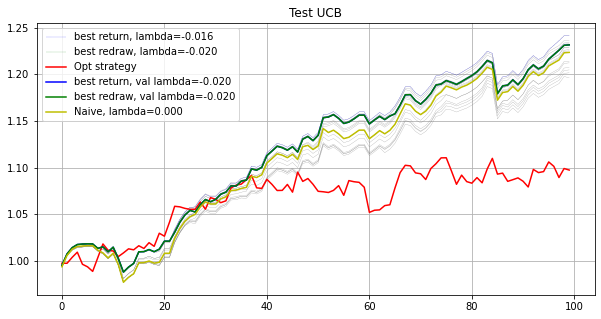

Phase 7
Validating...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.0086 0.0017 0.0111 0.0097 0.0028 0.     0.     0.0218
 0.     0.     0.     0.0391 0.0012 0.0043 0.0125 0.     0.0045 0.
 0.     0.005  0.     0.     0.     0.     0.0083 0.     0.     0.0272
 0.     0.     0.027  0.0083 0.0708 0.     0.     0.     0.     0.0269
 0.     0.0008 0.0414 0.007  0.     0.     0.0042 0.     0.021  0.
 0.0359 0.0503 0.     0.0797 0.0332 0.     0.     0.     0.0077 0.0115
 0.0183 0.     0.0144 0.     0.0159 0.0083 0.02   0.     0.0115 0.0035
 0.     0.0129 0.0066 0.     0.     0.0196 0.002  0.     0.     0.
 0.016  0.     0.     0.     0.0368 0.     0.     0.0263 0.0657 0.0929
 0.     0.     0.     0.     0.     0.011  0.0023 0.0076 0.0247 0.    ]
0.9969324634201447
[0.0109 0.     0.009  0.0027 0.009  0.0066 0.0021 0.     0.     0.001
 0.     0.     0.0254 0.     0.     0.0129 0.0015 0.0055 0.0081 0.
 0.     0.0091 0.     0.     0.     0.     0.0096 0.     0.     0.

[0.0067 0.0002 0.0083 0.     0.0088 0.0003 0.0013 0.     0.     0.0214
 0.0038 0.     0.     0.     0.     0.0275 0.     0.0008 0.0066 0.
 0.0004 0.0095 0.     0.0246 0.0009 0.     0.015  0.     0.     0.0158
 0.     0.     0.     0.0206 0.     0.0126 0.     0.0045 0.     0.
 0.0037 0.     0.0326 0.     0.0206 0.     0.0113 0.     0.     0.
 0.0291 0.0246 0.     0.043  0.     0.     0.     0.     0.     0.0037
 0.0108 0.0171 0.     0.     0.0151 0.     0.0232 0.     0.0045 0.
 0.0096 0.0097 0.     0.0155 0.026  0.0438 0.0003 0.0164 0.045  0.0955
 0.0055 0.0425 0.     0.     0.0259 0.     0.     0.0168 0.0525 0.0078
 0.     0.0324 0.0359 0.     0.     0.     0.0692 0.0051 0.0157 0.    ]
0.9990045475708957
[0.     0.     0.0069 0.0036 0.0003 0.009  0.0029 0.     0.     0.0092
 0.     0.     0.     0.0252 0.     0.     0.0029 0.     0.0249 0.
 0.0131 0.     0.     0.0231 0.0553 0.     0.002  0.     0.     0.0395
 0.     0.     0.0235 0.0029 0.0408 0.0324 0.     0.     0.     0.
 0.     0.

[0.     0.     0.0131 0.0061 0.0184 0.0136 0.0052 0.     0.     0.0241
 0.     0.     0.     0.0049 0.     0.     0.     0.0039 0.0086 0.
 0.     0.0076 0.     0.     0.     0.     0.017  0.     0.     0.0557
 0.     0.     0.     0.0106 0.     0.0114 0.     0.0566 0.     0.
 0.     0.     0.0145 0.     0.     0.0161 0.0234 0.     0.02   0.
 0.0317 0.     0.     0.0874 0.     0.     0.007  0.023  0.0014 0.
 0.0166 0.0222 0.0098 0.     0.0009 0.     0.     0.     0.0403 0.
 0.0308 0.0157 0.0322 0.     0.     0.0443 0.029  0.     0.0256 0.
 0.     0.01   0.0737 0.     0.0104 0.     0.     0.     0.     0.0275
 0.0127 0.     0.     0.     0.     0.0597 0.     0.0114 0.046  0.    ]
0.984994197950346
[0.     0.     0.0121 0.008  0.     0.0096 0.0067 0.     0.     0.0332
 0.     0.     0.     0.     0.     0.0042 0.     0.0088 0.0163 0.
 0.0376 0.0119 0.     0.0309 0.0123 0.     0.0147 0.     0.     0.0544
 0.     0.     0.0158 0.     0.     0.     0.     0.     0.     0.
 0.0355 0.     0.05

[0.     0.     0.0115 0.0042 0.0089 0.0207 0.0037 0.     0.     0.0358
 0.     0.     0.     0.     0.     0.0117 0.0048 0.     0.0381 0.
 0.0143 0.0189 0.     0.     0.     0.     0.011  0.     0.0039 0.0013
 0.     0.     0.0235 0.0154 0.     0.0004 0.     0.0004 0.     0.0282
 0.     0.0487 0.0572 0.0379 0.0396 0.     0.0192 0.     0.0375 0.0267
 0.0206 0.0039 0.     0.0566 0.     0.     0.0005 0.     0.0146 0.
 0.0237 0.     0.     0.     0.0123 0.     0.016  0.     0.     0.
 0.0393 0.     0.     0.     0.0133 0.0571 0.     0.0172 0.     0.
 0.0486 0.     0.     0.0543 0.     0.     0.     0.     0.0521 0.026
 0.     0.     0.     0.     0.     0.     0.     0.     0.0203 0.    ]
1.0133580671198439
[0.0064 0.     0.0101 0.0035 0.0057 0.0066 0.0035 0.     0.     0.0215
 0.     0.     0.     0.0207 0.     0.007  0.0212 0.     0.     0.
 0.0073 0.0196 0.     0.0105 0.     0.     0.0155 0.     0.     0.0439
 0.     0.     0.0162 0.0083 0.     0.021  0.0105 0.     0.     0.0022
 0.0016

[0.0083 0.     0.0107 0.0042 0.     0.     0.0041 0.     0.     0.0355
 0.0009 0.     0.     0.     0.     0.     0.     0.     0.0055 0.
 0.     0.0329 0.     0.0063 0.0029 0.     0.0114 0.     0.     0.0154
 0.     0.     0.0272 0.0094 0.     0.0231 0.0058 0.0314 0.     0.
 0.0005 0.     0.0411 0.     0.     0.008  0.0299 0.     0.0023 0.
 0.0406 0.0277 0.     0.0687 0.     0.     0.     0.     0.     0.0148
 0.0399 0.     0.0047 0.     0.     0.     0.0096 0.     0.     0.
 0.0084 0.     0.0068 0.0905 0.     0.0367 0.0093 0.     0.0612 0.0353
 0.0061 0.0093 0.     0.     0.0211 0.     0.     0.0254 0.0804 0.0036
 0.     0.     0.0094 0.     0.0137 0.004  0.     0.     0.025  0.031 ]
1.0043825894615663
[0.0022 0.     0.0084 0.0028 0.0071 0.0066 0.0044 0.     0.     0.017
 0.     0.     0.     0.     0.     0.     0.     0.0013 0.0137 0.
 0.     0.0165 0.     0.     0.0345 0.     0.0089 0.     0.     0.046
 0.     0.     0.     0.0015 0.1194 0.0148 0.     0.0119 0.     0.
 0.0059 0.  

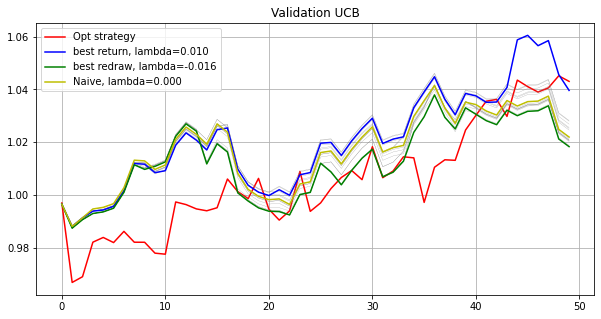

Testing...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09307256    Max redraw: 0.04027295
lambda: -0.018   Total log return: 0.09204683    Max redraw: 0.04117268
lambda: -0.016   Total log return: 0.09059912    Max redraw: 0.04117268
lambda: -0.014   Total log return: 0.09027487    Max redraw: 0.04117268
lambda: -0.012   Total log return: 0.09337694    Max redraw: 0.04117268
lambda: -0.010   Total log return: 0.09945863    Max redraw: 0.04027295
lambda: -0.008   Total log return: 0.10300035    Max redraw: 0.04027295
lambda: -0.006   Total log return: 0.10895820    Max redraw: 0.04027295
lambda: -0.004   Total log return: 0.10850160    Max redraw: 0.04027295
lambda: -0.002   Total log return: 0.10397950    Max redraw: 0.04027295
lambda: -0.000   Total log return: 0.09492290    Max redraw: 0.03980353
lambda: 0.002   Total log return: 0.09419810    Max redraw: 0.03980353
lambda: 0.004   Total log return: 0.07958077    Max redraw: 0.0398035

[0.0091 0.     0.0099 0.0027 0.0054 0.     0.0036 0.     0.     0.0201
 0.     0.0129 0.     0.     0.0055 0.     0.     0.     0.0137 0.0066
 0.     0.019  0.0136 0.0296 0.0469 0.     0.0146 0.     0.     0.0411
 0.     0.     0.     0.0083 0.     0.0117 0.0002 0.     0.0209 0.
 0.0095 0.     0.0396 0.     0.     0.0187 0.0207 0.0044 0.0087 0.0394
 0.0426 0.0119 0.     0.0554 0.     0.0077 0.     0.     0.011  0.0061
 0.002  0.0037 0.     0.     0.0235 0.0038 0.0073 0.     0.0055 0.
 0.0228 0.     0.0104 0.     0.005  0.0446 0.0089 0.     0.     0.0053
 0.0877 0.     0.     0.     0.     0.     0.     0.0382 0.     0.0157
 0.     0.004  0.035  0.     0.     0.0031 0.0898 0.0014 0.0113 0.    ]
1.000023753824739
[0.     0.     0.0107 0.0045 0.0089 0.008  0.0045 0.     0.     0.0216
 0.0062 0.     0.     0.     0.     0.     0.     0.     0.0301 0.
 0.0315 0.0079 0.     0.0301 0.0329 0.     0.0068 0.     0.     0.0482
 0.     0.     0.0649 0.     0.0084 0.019  0.0117 0.     0.0706 0.0028

[0.     0.     0.0083 0.     0.0071 0.     0.0022 0.     0.     0.0232
 0.017  0.     0.     0.0356 0.     0.0113 0.0152 0.     0.0132 0.
 0.     0.0301 0.     0.0336 0.     0.     0.0106 0.     0.     0.0155
 0.     0.     0.     0.0055 0.0002 0.0251 0.     0.     0.0231 0.0061
 0.0227 0.     0.0181 0.     0.0392 0.0115 0.0056 0.     0.0258 0.
 0.0214 0.021  0.0034 0.0585 0.     0.     0.0026 0.     0.0023 0.
 0.0084 0.     0.     0.     0.0292 0.     0.0265 0.     0.     0.
 0.0461 0.     0.0037 0.     0.0406 0.0473 0.0035 0.0046 0.009  0.
 0.     0.0074 0.     0.     0.0078 0.01   0.     0.     0.0989 0.1086
 0.     0.     0.     0.     0.     0.     0.     0.     0.004  0.0297]
1.0034354106659178
[0.0123 0.     0.0101 0.0004 0.0068 0.019  0.0057 0.     0.     0.0121
 0.     0.015  0.     0.     0.     0.0086 0.017  0.0068 0.0211 0.
 0.     0.0058 0.0194 0.0187 0.0234 0.     0.0097 0.     0.     0.0113
 0.     0.     0.0236 0.0086 0.     0.0374 0.0098 0.     0.1157 0.
 0.0156 0.    

[0.     0.     0.0114 0.0052 0.0106 0.0133 0.0065 0.     0.     0.023
 0.     0.0047 0.     0.     0.     0.     0.0006 0.018  0.021  0.
 0.0098 0.0045 0.     0.     0.     0.     0.0182 0.     0.     0.0498
 0.     0.     0.     0.0042 0.     0.0173 0.0044 0.0062 0.     0.0093
 0.     0.     0.0362 0.0155 0.0487 0.01   0.0297 0.     0.     0.
 0.0419 0.     0.     0.0579 0.     0.     0.004  0.0131 0.0141 0.0219
 0.0085 0.     0.     0.1188 0.0027 0.0027 0.0375 0.     0.     0.
 0.     0.0184 0.0227 0.     0.0034 0.071  0.     0.0159 0.     0.
 0.     0.0118 0.     0.     0.0202 0.     0.     0.     0.0097 0.025
 0.     0.0035 0.0162 0.0164 0.     0.     0.     0.0135 0.0508 0.    ]
1.006299970720461
[0.     0.     0.0103 0.0042 0.0037 0.     0.004  0.     0.     0.0409
 0.     0.     0.     0.     0.     0.033  0.     0.     0.0105 0.0054
 0.     0.0414 0.     0.0217 0.     0.     0.0129 0.     0.     0.
 0.     0.     0.0116 0.0186 0.     0.     0.     0.     0.     0.0104
 0.0134 0

[0.0057 0.     0.014  0.0007 0.0035 0.0122 0.0076 0.     0.     0.0355
 0.0016 0.     0.     0.     0.     0.0383 0.     0.0268 0.021  0.
 0.     0.0331 0.     0.031  0.     0.     0.0151 0.     0.     0.0068
 0.     0.     0.016  0.0079 0.     0.0084 0.0102 0.     0.     0.0007
 0.     0.     0.0071 0.006  0.0037 0.0133 0.0384 0.0049 0.0639 0.0283
 0.0338 0.     0.     0.0565 0.     0.     0.0187 0.     0.     0.
 0.0072 0.     0.027  0.     0.     0.     0.004  0.     0.     0.
 0.0448 0.     0.     0.     0.0448 0.0665 0.     0.     0.     0.
 0.     0.     0.     0.0574 0.0187 0.     0.     0.0421 0.0286 0.0288
 0.     0.     0.0196 0.     0.     0.     0.     0.     0.0398 0.    ]
0.9989809185358917
[0.     0.     0.0094 0.     0.     0.0058 0.0032 0.     0.     0.0179
 0.     0.     0.     0.     0.     0.     0.     0.     0.0065 0.
 0.0111 0.0021 0.     0.     0.0042 0.     0.0082 0.     0.     0.0441
 0.     0.     0.0155 0.     0.     0.0074 0.     0.     0.     0.0316
 0.   

[0.     0.     0.0117 0.0009 0.     0.0125 0.004  0.     0.     0.0212
 0.     0.     0.     0.     0.0011 0.0047 0.     0.     0.0092 0.0378
 0.014  0.0086 0.     0.0347 0.     0.     0.0101 0.     0.     0.0398
 0.     0.     0.     0.0026 0.     0.     0.0016 0.     0.0126 0.0089
 0.0055 0.0216 0.0055 0.     0.0121 0.     0.0323 0.     0.0309 0.0495
 0.0346 0.0009 0.0126 0.0489 0.     0.     0.     0.     0.     0.0019
 0.062  0.     0.     0.     0.0341 0.0245 0.0257 0.     0.0189 0.
 0.     0.     0.0004 0.     0.0133 0.0377 0.0005 0.     0.     0.
 0.     0.     0.     0.     0.0111 0.     0.     0.0541 0.008  0.1248
 0.     0.0103 0.0201 0.     0.     0.0148 0.     0.     0.0276 0.0195]
1.0002408451153348
[0.     0.     0.0095 0.0008 0.0088 0.     0.0038 0.     0.0091 0.008
 0.0095 0.     0.     0.     0.0007 0.0098 0.     0.0015 0.008  0.
 0.0171 0.0146 0.     0.     0.0343 0.     0.0124 0.     0.     0.0338
 0.     0.     0.0218 0.0342 0.     0.0123 0.0011 0.     0.0709 0.0218

[0.0124 0.0249 0.0099 0.0014 0.0043 0.0096 0.004  0.     0.     0.0366
 0.     0.     0.     0.0236 0.     0.007  0.     0.0003 0.0232 0.
 0.0374 0.0337 0.     0.     0.     0.     0.0072 0.     0.     0.0189
 0.     0.     0.0107 0.0251 0.     0.0054 0.0003 0.     0.0413 0.0095
 0.0048 0.     0.0123 0.002  0.0583 0.     0.0266 0.     0.0127 0.0158
 0.0445 0.     0.     0.0555 0.     0.     0.     0.     0.0003 0.0049
 0.     0.     0.     0.     0.     0.     0.0278 0.     0.0078 0.
 0.0301 0.     0.0029 0.     0.0236 0.0664 0.     0.     0.     0.
 0.     0.     0.     0.0533 0.0441 0.0368 0.     0.028  0.015  0.
 0.     0.     0.0473 0.     0.     0.     0.     0.     0.0328 0.    ]
0.9990369042197385
[0.     0.     0.0128 0.0075 0.003  0.0068 0.007  0.     0.     0.0332
 0.     0.     0.     0.     0.     0.0088 0.     0.     0.05   0.
 0.0102 0.009  0.     0.     0.     0.     0.0175 0.     0.     0.0255
 0.     0.     0.     0.     0.0123 0.     0.0134 0.     0.     0.0026
 0.   

[0.     0.     0.0119 0.0024 0.0048 0.0171 0.0064 0.     0.     0.0206
 0.     0.     0.     0.     0.0058 0.     0.017  0.0033 0.0092 0.
 0.0365 0.0131 0.     0.     0.     0.002  0.0162 0.     0.     0.0214
 0.     0.     0.002  0.0121 0.     0.0169 0.     0.0213 0.0701 0.
 0.     0.     0.0229 0.0146 0.     0.0034 0.0283 0.     0.0408 0.
 0.0331 0.0251 0.0144 0.0801 0.     0.     0.     0.     0.     0.003
 0.013  0.     0.     0.     0.0247 0.0099 0.     0.     0.     0.
 0.0025 0.     0.     0.087  0.0524 0.0137 0.     0.0333 0.     0.
 0.     0.     0.     0.0042 0.     0.     0.     0.     0.0424 0.0191
 0.     0.0445 0.0485 0.     0.     0.     0.     0.     0.0286 0.    ]
1.005944871837936
[0.0195 0.0018 0.0096 0.0027 0.0085 0.0053 0.0005 0.     0.     0.0069
 0.     0.     0.     0.0073 0.0014 0.     0.0392 0.     0.027  0.
 0.     0.     0.0193 0.     0.     0.     0.0092 0.     0.     0.0233
 0.0061 0.     0.     0.0073 0.     0.0187 0.     0.     0.     0.0208
 0.     0.  

[0.     0.     0.0126 0.0059 0.0029 0.0036 0.0067 0.     0.     0.
 0.     0.0024 0.     0.     0.0084 0.0297 0.0131 0.0128 0.0176 0.
 0.0104 0.0123 0.     0.     0.0184 0.0011 0.0167 0.     0.     0.0689
 0.     0.     0.     0.0212 0.     0.0358 0.     0.     0.     0.
 0.     0.     0.022  0.     0.022  0.0112 0.0261 0.0051 0.061  0.
 0.0236 0.0012 0.     0.0628 0.     0.     0.0013 0.     0.006  0.0022
 0.0129 0.     0.     0.     0.     0.     0.0503 0.     0.     0.
 0.0195 0.     0.     0.     0.0842 0.0087 0.0072 0.0037 0.     0.
 0.     0.     0.     0.     0.046  0.     0.     0.     0.0728 0.0354
 0.     0.     0.0409 0.014  0.     0.     0.     0.     0.0594 0.    ]
1.0075512102215058
[0.     0.     0.0103 0.0015 0.0018 0.0081 0.0041 0.     0.     0.0415
 0.0057 0.0014 0.     0.     0.0072 0.0008 0.0079 0.     0.0153 0.
 0.     0.015  0.     0.0024 0.01   0.     0.0139 0.     0.     0.026
 0.     0.     0.0387 0.011  0.     0.0274 0.0097 0.     0.     0.
 0.0111 0.     0.05

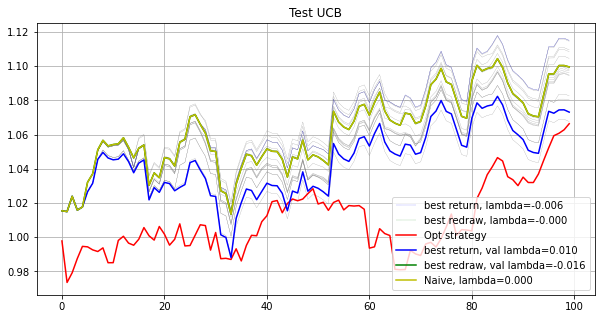

Phase 8
Validating...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.0291 0.0113 0.0085 0.0117 0.0068 0.     0.     0.
 0.0078 0.     0.0266 0.0091 0.     0.0118 0.     0.     0.     0.
 0.     0.0535 0.     0.024  0.0072 0.     0.0076 0.     0.0145 0.0375
 0.     0.     0.     0.0111 0.     0.     0.     0.     0.0088 0.
 0.     0.     0.     0.     0.0064 0.     0.     0.     0.     0.
 0.0269 0.0375 0.     0.0666 0.0369 0.     0.     0.0048 0.     0.0288
 0.     0.     0.     0.     0.0169 0.0033 0.     0.     0.0006 0.
 0.     0.     0.     0.     0.0981 0.     0.     0.     0.0458 0.1171
 0.     0.083  0.     0.     0.     0.     0.     0.     0.0159 0.
 0.     0.0265 0.     0.     0.     0.     0.0495 0.0116 0.0192 0.0175]
1.0037630194605849
[0.     0.     0.     0.0125 0.01   0.     0.0082 0.     0.     0.0042
 0.0011 0.     0.0269 0.     0.     0.     0.     0.     0.0008 0.0589
 0.     0.0218 0.     0.0258 0.0017 0.     0.     0.0017 0.0046 0.0129
 0

[0.     0.001  0.0108 0.0003 0.0021 0.     0.0031 0.     0.0101 0.
 0.     0.0027 0.0122 0.0015 0.     0.     0.     0.     0.0274 0.0116
 0.     0.0072 0.     0.0117 0.0356 0.     0.0011 0.     0.006  0.0208
 0.0758 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0258 0.     0.     0.     0.     0.     0.0204 0.0021
 0.     0.0175 0.     0.0593 0.0176 0.0023 0.0111 0.     0.     0.0179
 0.     0.     0.     0.     0.0101 0.     0.     0.     0.0107 0.
 0.     0.0189 0.     0.02   0.0375 0.0892 0.     0.0261 0.0002 0.006
 0.     0.0145 0.     0.     0.     0.0045 0.     0.     0.     0.
 0.     0.     0.     0.     0.069  0.2111 0.0449 0.0014 0.021  0.    ]
1.0060480791368012
[0.     0.     0.     0.0067 0.0031 0.     0.0037 0.     0.     0.0205
 0.0061 0.     0.0225 0.0031 0.     0.     0.     0.     0.0167 0.0155
 0.0102 0.0191 0.     0.0088 0.0235 0.     0.0002 0.     0.0106 0.0693
 0.0225 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.    

[0.     0.005  0.     0.0086 0.0072 0.     0.0032 0.     0.     0.
 0.0259 0.     0.0289 0.0203 0.     0.     0.     0.     0.0184 0.
 0.02   0.0079 0.     0.0298 0.0318 0.     0.     0.     0.     0.0098
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0049 0.     0.0255 0.0067 0.     0.0329 0.0081 0.
 0.0298 0.0151 0.     0.     0.0453 0.     0.     0.0365 0.     0.0405
 0.     0.     0.     0.     0.     0.0374 0.0205 0.     0.     0.
 0.1692 0.     0.0095 0.     0.0012 0.     0.0009 0.     0.     0.0691
 0.0144 0.     0.     0.     0.     0.     0.     0.     0.     0.0035
 0.     0.0469 0.     0.     0.     0.0635 0.0667 0.     0.0096 0.0255]
1.003940923886759
[0.     0.     0.0143 0.0048 0.0044 0.     0.0026 0.     0.     0.
 0.0041 0.0112 0.0128 0.0143 0.     0.     0.     0.     0.0358 0.0106
 0.     0.0109 0.     0.0071 0.     0.     0.     0.     0.     0.005
 0.0527 0.     0.     0.0351 0.     0.0776 0.     0.     0.0008 0.
 0.     0.     0

[0.     0.     0.0072 0.0045 0.0029 0.     0.0016 0.     0.     0.0091
 0.     0.     0.     0.001  0.     0.     0.     0.0001 0.     0.
 0.0039 0.0679 0.0127 0.     0.0643 0.     0.     0.     0.0153 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0044 0.     0.     0.     0.0074 0.     0.0326 0.0037 0.     0.
 0.1108 0.0189 0.     0.     0.0241 0.     0.0774 0.0574 0.     0.0067
 0.     0.     0.     0.0231 0.005  0.     0.0451 0.     0.0077 0.
 0.0396 0.004  0.     0.     0.     0.     0.     0.0312 0.0911 0.0023
 0.0245 0.     0.     0.     0.     0.     0.     0.     0.041  0.
 0.     0.0378 0.     0.     0.     0.0189 0.0825 0.0043 0.0082 0.    ]
1.0062038029104905
[0.     0.     0.0258 0.0052 0.0045 0.     0.     0.     0.     0.
 0.     0.     0.0163 0.0233 0.     0.     0.     0.     0.0463 0.0171
 0.0274 0.0166 0.     0.0148 0.0104 0.     0.     0.     0.     0.
 0.     0.     0.     0.0392 0.     0.     0.     0.     0.     0.
 0.     0.     0.     

[0.     0.     0.     0.0055 0.004  0.     0.0037 0.     0.0197 0.
 0.     0.0215 0.0153 0.0138 0.     0.     0.     0.     0.     0.
 0.0075 0.     0.0098 0.0198 0.0411 0.     0.     0.     0.     0.0931
 0.     0.0073 0.     0.     0.     0.     0.     0.0024 0.     0.0035
 0.     0.     0.0534 0.0199 0.0115 0.0055 0.0135 0.0184 0.     0.0073
 0.0528 0.     0.     0.053  0.0301 0.     0.0362 0.     0.     0.0327
 0.0072 0.     0.     0.     0.0088 0.     0.     0.     0.     0.
 0.1252 0.     0.     0.     0.     0.0335 0.     0.     0.     0.0273
 0.0645 0.0043 0.     0.     0.     0.     0.     0.     0.0104 0.0128
 0.     0.     0.     0.     0.     0.     0.0841 0.0056 0.0141 0.    ]
0.9968699063778255
[0.     0.     0.     0.0037 0.0017 0.     0.0007 0.     0.     0.
 0.     0.     0.0161 0.0224 0.     0.     0.     0.     0.0245 0.0063
 0.     0.0594 0.     0.     0.     0.     0.     0.0003 0.0151 0.0185
 0.0232 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.   

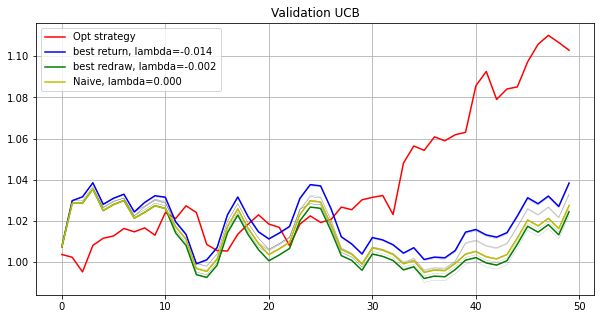

Testing...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.018   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.016   Total log return: 0.04548496    Max redraw: 0.04154353
lambda: -0.014   Total log return: 0.04087616    Max redraw: 0.04154353
lambda: -0.012   Total log return: 0.03717725    Max redraw: 0.04154353
lambda: -0.010   Total log return: 0.04226571    Max redraw: 0.04154353
lambda: -0.008   Total log return: 0.04410808    Max redraw: 0.04154353
lambda: -0.006   Total log return: 0.04088311    Max redraw: 0.04154353
lambda: -0.004   Total log return: 0.04586607    Max redraw: 0.04154353
lambda: -0.002   Total log return: 0.04682497    Max redraw: 0.04154353
lambda: -0.000   Total log return: 0.04745435    Max redraw: 0.04154353
lambda: 0.002   Total log return: 0.04386840    Max redraw: 0.04154353
lambda: 0.004   Total log return: 0.05685098    Max redraw: 0.0415435

[0.     0.     0.015  0.0089 0.0086 0.     0.0047 0.     0.     0.0055
 0.     0.     0.0273 0.0508 0.     0.0091 0.     0.     0.     0.
 0.     0.0015 0.     0.0254 0.     0.002  0.     0.     0.0031 0.0894
 0.     0.     0.     0.0304 0.     0.0406 0.     0.     0.     0.
 0.     0.     0.0242 0.0212 0.0302 0.     0.0232 0.0401 0.     0.0012
 0.0956 0.0215 0.     0.     0.0291 0.     0.     0.0307 0.0225 0.0118
 0.0357 0.     0.     0.0402 0.0104 0.     0.     0.     0.     0.
 0.     0.     0.0071 0.     0.     0.     0.     0.0522 0.     0.1234
 0.     0.     0.     0.     0.     0.0095 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0431 0.     0.0046 0.    ]
1.0015660353157358
[0.     0.     0.0152 0.0108 0.0098 0.     0.0081 0.     0.     0.
 0.0054 0.     0.02   0.0253 0.     0.     0.     0.     0.     0.0407
 0.     0.021  0.     0.0158 0.0482 0.     0.004  0.0096 0.     0.0183
 0.0193 0.0027 0.     0.     0.     0.     0.     0.028  0.0108 0.
 0.     0.

[0.     0.0041 0.     0.0068 0.0083 0.     0.0065 0.     0.0352 0.
 0.     0.0368 0.023  0.0017 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0278 0.     0.     0.     0.     0.     0.0292
 0.038  0.0067 0.     0.     0.     0.     0.     0.     0.0044 0.0219
 0.     0.     0.0059 0.     0.     0.     0.029  0.0046 0.     0.
 0.     0.     0.     0.001  0.0383 0.     0.     0.0194 0.     0.0243
 0.     0.     0.     0.     0.     0.     0.     0.     0.0086 0.
 0.     0.     0.     0.     0.     0.015  0.     0.0495 0.067  0.
 0.     0.0402 0.     0.     0.     0.     0.1094 0.     0.1104 0.
 0.0149 0.0662 0.     0.     0.0776 0.     0.024  0.0263 0.0181 0.    ]
0.9948069008545072
[0.     0.     0.0257 0.0025 0.0007 0.     0.0003 0.     0.     0.0167
 0.0062 0.     0.0096 0.0428 0.     0.     0.     0.     0.0151 0.0278
 0.     0.0491 0.     0.0094 0.0854 0.     0.     0.     0.     0.05
 0.0267 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0

[0.     0.0085 0.0087 0.0029 0.0017 0.0074 0.0049 0.     0.     0.
 0.     0.     0.0162 0.0234 0.0167 0.0316 0.     0.0285 0.     0.0079
 0.     0.0215 0.     0.0256 0.     0.     0.     0.004  0.     0.0204
 0.     0.0015 0.     0.0149 0.     0.     0.     0.     0.0069 0.
 0.     0.     0.0086 0.     0.     0.0268 0.     0.     0.0113 0.
 0.     0.029  0.     0.     0.0288 0.0327 0.     0.     0.     0.0361
 0.     0.     0.     0.     0.     0.     0.     0.     0.0103 0.
 0.     0.0352 0.     0.0189 0.     0.0033 0.     0.0166 0.     0.
 0.     0.     0.     0.     0.     0.     0.1053 0.     0.     0.
 0.     0.0356 0.     0.     0.0996 0.202  0.0244 0.0061 0.0161 0.    ]
1.0067782440289468
[0.     0.     0.0352 0.0085 0.0041 0.0067 0.0066 0.     0.0144 0.
 0.0012 0.     0.0257 0.     0.0028 0.     0.     0.     0.     0.0313
 0.     0.0118 0.     0.0131 0.0602 0.     0.     0.0027 0.     0.0351
 0.001  0.     0.     0.     0.     0.     0.     0.0345 0.     0.
 0.     0.     0.0

[0.     0.     0.0064 0.0078 0.005  0.009  0.0009 0.     0.     0.
 0.     0.     0.0101 0.0262 0.     0.     0.     0.     0.0018 0.0221
 0.     0.0125 0.     0.01   0.0197 0.     0.     0.     0.     0.0519
 0.0162 0.     0.     0.0061 0.     0.     0.     0.     0.     0.
 0.     0.0038 0.0178 0.     0.     0.     0.     0.     0.     0.0336
 0.0653 0.     0.     0.017  0.0281 0.     0.0428 0.0331 0.     0.0092
 0.     0.     0.     0.     0.0024 0.0005 0.0167 0.1268 0.     0.
 0.     0.     0.     0.     0.     0.0555 0.     0.     0.0032 0.042
 0.     0.0362 0.     0.0245 0.     0.0518 0.0451 0.     0.     0.0568
 0.     0.     0.0211 0.     0.     0.0611 0.     0.     0.     0.    ]
1.0145256084549519
[0.     0.     0.     0.0098 0.0105 0.0033 0.0071 0.     0.     0.0142
 0.     0.     0.0254 0.     0.     0.     0.     0.     0.     0.0277
 0.     0.0211 0.     0.0215 0.     0.     0.     0.     0.     0.1077
 0.     0.     0.     0.001  0.     0.     0.     0.     0.     0.
 0.

[0.0109 0.     0.0155 0.0026 0.     0.0013 0.     0.     0.     0.
 0.     0.0217 0.0105 0.0298 0.0007 0.     0.     0.     0.     0.0074
 0.0178 0.0161 0.     0.     0.     0.     0.     0.     0.     0.0397
 0.0032 0.     0.     0.     0.     0.     0.     0.0569 0.     0.
 0.0281 0.     0.0166 0.0415 0.0398 0.0093 0.     0.     0.     0.
 0.     0.     0.     0.0304 0.0002 0.0062 0.     0.     0.     0.0076
 0.0837 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0216 0.029  0.     0.     0.     0.1633 0.     0.029  0.     0.
 0.     0.1156 0.     0.     0.     0.0168 0.     0.     0.     0.
 0.     0.     0.     0.     0.0269 0.0189 0.0494 0.     0.0325 0.    ]
0.9969897125585316
[0.     0.     0.0227 0.0009 0.0003 0.0099 0.     0.     0.     0.0276
 0.     0.     0.0081 0.     0.0027 0.     0.     0.     0.     0.0053
 0.0113 0.0142 0.0162 0.     0.0715 0.     0.     0.     0.0108 0.0262
 0.0167 0.     0.     0.     0.     0.     0.     0.     0.0023 0.0751
 0.     0.

[0.0576 0.0024 0.0214 0.006  0.0054 0.0019 0.0059 0.     0.     0.0352
 0.0002 0.     0.0125 0.0123 0.0108 0.     0.0077 0.     0.     0.
 0.     0.027  0.     0.0186 0.0206 0.     0.0094 0.01   0.     0.0498
 0.0024 0.     0.     0.0228 0.     0.     0.0017 0.     0.     0.
 0.     0.0708 0.0343 0.0051 0.0592 0.     0.     0.     0.0002 0.
 0.0174 0.0048 0.     0.0057 0.0216 0.0853 0.     0.0103 0.     0.0324
 0.     0.     0.     0.     0.     0.     0.0193 0.     0.0066 0.
 0.0377 0.0098 0.     0.     0.     0.0161 0.0023 0.     0.     0.0187
 0.0381 0.0463 0.     0.     0.     0.     0.0292 0.     0.0001 0.
 0.     0.     0.     0.     0.     0.0213 0.0125 0.0307 0.0226 0.    ]
1.004649367550759
[0.     0.     0.0077 0.0072 0.0069 0.     0.     0.     0.     0.
 0.0064 0.     0.0191 0.0294 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0121 0.0347 0.     0.     0.     0.     0.0464
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0958 0.  

[0.     0.0059 0.0156 0.0016 0.0024 0.     0.     0.     0.     0.
 0.     0.0211 0.0129 0.0416 0.     0.     0.     0.     0.0157 0.
 0.     0.0121 0.     0.0099 0.0212 0.     0.     0.     0.0227 0.
 0.0314 0.     0.0414 0.0166 0.     0.139  0.     0.     0.     0.
 0.     0.     0.     0.     0.0055 0.0358 0.     0.     0.     0.
 0.0436 0.     0.     0.1029 0.0176 0.     0.     0.031  0.0152 0.
 0.     0.     0.     0.0569 0.     0.     0.0384 0.     0.     0.
 0.0339 0.     0.     0.0217 0.     0.0338 0.     0.0282 0.04   0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0079 0.
 0.     0.0409 0.     0.     0.     0.     0.0178 0.0074 0.0101 0.    ]
0.9944208042084546
[0.     0.     0.0236 0.0085 0.0066 0.     0.0038 0.     0.     0.
 0.     0.0036 0.0086 0.0506 0.     0.     0.     0.     0.034  0.
 0.     0.0278 0.     0.022  0.     0.     0.     0.     0.     0.074
 0.056  0.     0.     0.     0.     0.0122 0.     0.0354 0.012  0.
 0.     0.     0.0031 0.0078 0.    

[0.     0.0067 0.0266 0.0041 0.0055 0.0024 0.0022 0.     0.     0.0187
 0.     0.     0.0179 0.     0.     0.     0.     0.     0.     0.
 0.     0.0208 0.     0.0158 0.     0.     0.     0.0054 0.     0.0555
 0.0125 0.     0.     0.0327 0.     0.     0.     0.0774 0.0139 0.
 0.     0.0244 0.     0.     0.0206 0.     0.     0.     0.     0.
 0.     0.     0.     0.0142 0.0281 0.     0.     0.     0.     0.023
 0.0431 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0929 0.     0.     0.     0.095  0.     0.     0.     0.
 0.     0.0927 0.     0.     0.     0.     0.     0.0181 0.     0.
 0.     0.0162 0.     0.     0.     0.     0.1119 0.0372 0.0399 0.0243]
0.9713619917236709
[0.     0.     0.022  0.0002 0.     0.     0.     0.     0.     0.
 0.     0.     0.0065 0.     0.0054 0.     0.     0.     0.0103 0.0791
 0.     0.0414 0.     0.0026 0.0186 0.     0.     0.     0.0167 0.0448
 0.     0.     0.     0.     0.     0.     0.     0.0142 0.     0.
 0.     0.     0.  

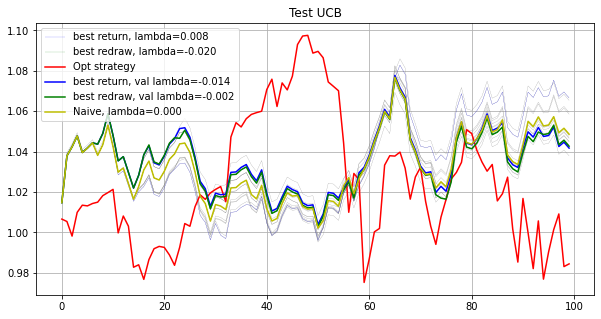

Phase 9
Validating...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.     0.     0.     0.     0.     0.0225 0.
 0.     0.0052 0.     0.     0.0051 0.0177 0.0143 0.     0.1174 0.
 0.     0.     0.     0.     0.006  0.     0.0125 0.     0.     0.
 0.     0.0036 0.     0.     0.1083 0.     0.     0.     0.     0.
 0.0284 0.0807 0.     0.     0.0342 0.0156 0.0733 0.     0.     0.
 0.     0.0317 0.     0.     0.     0.     0.     0.     0.0289 0.
 0.     0.     0.0062 0.     0.     0.     0.0255 0.     0.     0.
 0.     0.     0.1931 0.     0.     0.0406 0.     0.     0.     0.0133
 0.0353 0.048  0.     0.     0.0073 0.     0.     0.0157 0.     0.0096
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
1.0266531012814455
[0.     0.0408 0.     0.     0.     0.0078 0.0744 0.     0.0151 0.
 0.     0.     0.     0.     0.     0.1338 0.     0.     0.     0.
 0.     0.     0.     0.     0.0223 0.     0.0267 0.     0.     0.0152
 0.     0.    

[0.     0.0351 0.     0.     0.     0.     0.     0.0724 0.0066 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0481 0.
 0.     0.     0.     0.     0.0787 0.     0.0145 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0268 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0616 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.004  0.
 0.     0.     0.     0.     0.0428 0.0394 0.     0.     0.     0.
 0.     0.     0.     0.     0.0366 0.0261 0.     0.     0.     0.
 0.     0.1237 0.0037 0.     0.     0.101  0.     0.     0.     0.124
 0.     0.     0.0659 0.     0.     0.     0.     0.     0.0645 0.0242]
1.0247725587174583
[0.     0.0158 0.     0.0492 0.     0.     0.     0.0264 0.0007 0.
 0.0003 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0361 0.0249 0.     0.     0.     0.     0.0723 0.0307 0.     0.
 0.     0.     0.     0.     0.     0.     0.0201 0.     0.     0.
 0.0859 0.     0.     0.     0.    

[0.     0.     0.     0.     0.     0.0033 0.     0.0015 0.0061 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0192 0.     0.     0.     0.056  0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1684 0.     0.
 0.     0.0123 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0142 0.     0.     0.     0.     0.     0.     0.0084 0.
 0.     0.     0.     0.     0.0597 0.0159 0.     0.0443 0.     0.
 0.     0.     0.     0.0152 0.     0.0029 0.     0.     0.0365 0.0349
 0.0078 0.1825 0.0488 0.     0.0712 0.     0.     0.     0.0337 0.
 0.0347 0.     0.0869 0.     0.     0.     0.     0.     0.0354 0.    ]
1.0046261865934785
[0.     0.0514 0.     0.     0.     0.     0.     0.     0.021  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0216 0.     0.0737 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0597 0.     0.     0.   

[0.     0.     0.     0.     0.     0.     0.     0.     0.0064 0.
 0.     0.     0.002  0.     0.     0.0108 0.     0.     0.     0.
 0.     0.     0.     0.     0.1056 0.0743 0.     0.0226 0.     0.
 0.     0.0376 0.0085 0.     0.     0.     0.     0.     0.     0.
 0.0119 0.0728 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0948 0.     0.002  0.
 0.     0.     0.     0.     0.008  0.0127 0.0207 0.     0.     0.0362
 0.     0.     0.     0.     0.     0.001  0.     0.     0.     0.
 0.     0.2198 0.0095 0.     0.041  0.     0.     0.0236 0.0331 0.
 0.0011 0.     0.     0.     0.     0.     0.     0.0628 0.0549 0.0263]
0.9911108554302586
[0.     0.0145 0.     0.     0.     0.     0.     0.0396 0.0239 0.
 0.0138 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0843 0.     0.     0.     0.     0.     0.0703 0.0328 0.     0.
 0.     0.     0.1348 0.     0.     0.     0.     0.     0.0016 0.
 0.     0.     0.     0.     0.   

[0.     0.0217 0.     0.     0.     0.     0.     0.     0.0116 0.
 0.0004 0.     0.     0.     0.     0.0136 0.     0.     0.     0.
 0.0387 0.     0.     0.     0.0802 0.005  0.0117 0.0431 0.     0.
 0.     0.0046 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0046 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0801 0.     0.     0.
 0.     0.     0.212  0.     0.     0.     0.     0.     0.     0.
 0.0713 0.     0.0105 0.     0.0101 0.     0.0315 0.1149 0.0853 0.
 0.     0.     0.0033 0.     0.     0.     0.1316 0.     0.0141 0.    ]
0.9983109318081885
[0.     0.     0.     0.     0.     0.     0.     0.     0.0086 0.
 0.0094 0.     0.     0.     0.     0.0516 0.     0.     0.     0.
 0.0093 0.     0.     0.     0.029  0.     0.     0.     0.     0.
 0.     0.0111 0.     0.     0.     0.     0.     0.     0.     0.
 0.075  0.0676 0.     0.     0.     0.

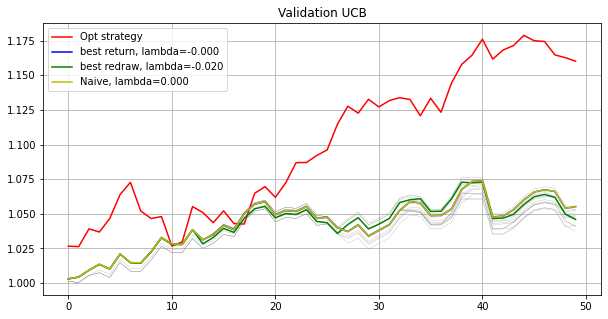

Testing...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09169513    Max redraw: 0.03340976
lambda: -0.018   Total log return: 0.09705971    Max redraw: 0.03340976
lambda: -0.016   Total log return: 0.08685545    Max redraw: 0.03340976
lambda: -0.014   Total log return: 0.09649924    Max redraw: 0.03340976
lambda: -0.012   Total log return: 0.09522997    Max redraw: 0.03340976
lambda: -0.010   Total log return: 0.10101991    Max redraw: 0.03267943
lambda: -0.008   Total log return: 0.10152567    Max redraw: 0.03267943
lambda: -0.006   Total log return: 0.10408528    Max redraw: 0.03267943
lambda: -0.004   Total log return: 0.10237535    Max redraw: 0.03267943
lambda: -0.002   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: -0.000   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: 0.002   Total log return: 0.10785830    Max redraw: 0.03267943
lambda: 0.004   Total log return: 0.10442110    Max redraw: 0.0326794

[0.     0.0276 0.     0.     0.     0.     0.0247 0.     0.0296 0.
 0.     0.     0.     0.     0.     0.0789 0.     0.     0.008  0.
 0.     0.     0.     0.     0.0884 0.0261 0.     0.     0.     0.
 0.     0.     0.     0.     0.0308 0.     0.     0.     0.     0.0254
 0.     0.0416 0.     0.     0.     0.0092 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0002 0.     0.0186 0.     0.     0.
 0.     0.     0.     0.0077 0.     0.0426 0.     0.     0.     0.
 0.     0.2225 0.     0.     0.     0.     0.     0.0628 0.0535 0.
 0.065  0.     0.0779 0.     0.     0.     0.0142 0.     0.0448 0.    ]
0.9833883183613075
[0.     0.0209 0.     0.     0.     0.     0.0259 0.     0.0102 0.
 0.     0.     0.     0.     0.     0.0553 0.     0.     0.     0.
 0.0387 0.     0.     0.     0.0105 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0081
 0.     0.0316 0.     0.     0

[0.     0.     0.     0.     0.     0.     0.     0.     0.0101 0.
 0.0391 0.001  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0583 0.     0.     0.0193 0.     0.     0.     0.     0.
 0.     0.     0.1063 0.     0.     0.     0.     0.     0.     0.
 0.0692 0.     0.     0.     0.     0.0202 0.     0.     0.0587 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1164 0.     0.0626 0.     0.     0.0864
 0.     0.     0.     0.     0.     0.     0.     0.     0.0657 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.1053 0.     0.     0.     0.     0.     0.     0.1815]
1.008271879837044
[0.     0.0295 0.     0.     0.     0.     0.0438 0.0085 0.0151 0.
 0.     0.     0.     0.     0.     0.0948 0.     0.     0.     0.
 0.     0.     0.     0.     0.0743 0.0013 0.0275 0.0186 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1148 0.     0.
 0.     0.0491 0.     0.0155 0.    

[0.     0.0166 0.     0.     0.     0.     0.     0.0036 0.0137 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0119 0.0592 0.071  0.     0.     0.
 0.     0.     0.     0.     0.0878 0.     0.     0.     0.     0.
 0.     0.1435 0.     0.     0.     0.0003 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0622 0.     0.     0.
 0.0351 0.     0.0016 0.     0.0083 0.0283 0.     0.     0.     0.
 0.     0.     0.     0.008  0.     0.     0.0039 0.     0.     0.
 0.0223 0.0455 0.0021 0.     0.0258 0.     0.     0.     0.0341 0.
 0.     0.0678 0.     0.     0.     0.     0.1831 0.     0.     0.0643]
0.9912935992944235
[0.     0.     0.     0.     0.     0.     0.0714 0.     0.0178 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0922 0.     0.     0.     0.     0.
 0.0002 0.0253 0.     0.     0.0189 0.     0.     0.     0.0166 0.
 0.1199 0.004  0.     0.1242 0.     0.

[0.     0.     0.     0.     0.     0.     0.     0.0065 0.0255 0.
 0.     0.     0.     0.     0.     0.0206 0.     0.     0.     0.
 0.0107 0.     0.     0.     0.0655 0.0014 0.0012 0.     0.     0.
 0.     0.     0.0067 0.     0.0232 0.     0.     0.     0.     0.
 0.     0.0773 0.0008 0.     0.     0.0185 0.0285 0.     0.0155 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0247 0.     0.     0.     0.     0.     0.1703 0.15   0.     0.
 0.     0.     0.1461 0.     0.     0.045  0.     0.     0.     0.
 0.     0.     0.     0.     0.0698 0.     0.     0.     0.     0.
 0.     0.     0.0921 0.     0.     0.     0.     0.     0.     0.    ]
1.0031633704306948
[0.     0.0342 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0034 0.     0.     0.015  0.
 0.     0.     0.     0.     0.     0.0097 0.0474 0.     0.     0.
 0.     0.     0.0645 0.     0.     0.     0.     0.     0.017  0.
 0.     0.0608 0.     0.     0.0261 0.

[0.     0.0452 0.     0.0575 0.     0.0029 0.0526 0.0086 0.0127 0.
 0.     0.0011 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0005 0.     0.     0.1038 0.     0.     0.     0.     0.
 0.0238 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0245 0.     0.     0.     0.     0.0288 0.     0.     0.
 0.1017 0.     0.     0.     0.     0.     0.     0.     0.0153 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.008  0.0048 0.     0.0843 0.
 0.     0.1707 0.045  0.     0.     0.     0.0234 0.     0.0865 0.
 0.     0.     0.     0.     0.     0.     0.0586 0.     0.0356 0.0042]
0.9991913391554601
[0.     0.     0.     0.     0.     0.     0.0083 0.     0.0024 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0696 0.     0.     0.     0.     0.     0.0671 0.     0.     0.
 0.     0.     0.088  0.     0.0694 0.     0.0016 0.     0.     0.
 0.     0.0454 0.     0.0423 0.     0.

[0.     0.0016 0.     0.     0.     0.     0.0747 0.     0.0192 0.
 0.0436 0.0025 0.     0.     0.     0.0154 0.     0.     0.0035 0.
 0.     0.     0.     0.     0.1377 0.0071 0.     0.     0.     0.
 0.     0.015  0.0034 0.     0.     0.     0.     0.     0.0159 0.0012
 0.     0.0005 0.0064 0.     0.     0.0031 0.0777 0.     0.     0.
 0.     0.0194 0.     0.     0.0919 0.     0.003  0.     0.039  0.
 0.     0.     0.0141 0.     0.     0.     0.1051 0.     0.     0.
 0.     0.     0.     0.     0.     0.0786 0.     0.     0.     0.
 0.0636 0.     0.0166 0.     0.     0.     0.     0.     0.0576 0.
 0.     0.     0.013  0.     0.     0.     0.     0.     0.0695 0.    ]
0.9977093638717807
[0.     0.     0.     0.0153 0.     0.     0.     0.     0.0487 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0015 0.     0.     0.     0.025  0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0423 0.     0.     0.     0.     0.
 0.     0.0356 0.     0.     0.   

[0.     0.0082 0.     0.     0.     0.     0.     0.     0.0082 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0062 0.
 0.0045 0.     0.     0.     0.0668 0.     0.007  0.     0.     0.
 0.     0.032  0.0294 0.     0.     0.     0.     0.     0.     0.
 0.     0.0662 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1333 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0434 0.0246 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0493 0.     0.     0.     0.
 0.0431 0.1581 0.     0.     0.     0.     0.     0.     0.0902 0.0043
 0.     0.     0.     0.     0.     0.     0.1189 0.     0.1062 0.    ]
1.0059522212637582
[0.     0.     0.     0.     0.     0.     0.     0.0418 0.0392 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0858 0.     0.0564 0.     0.     0.
 0.     0.     0.     0.     0.0439 0.     0.0137 0.     0.     0.
 0.     0.0574 0.     0.     0.   

[0.     0.     0.     0.0815 0.     0.     0.     0.     0.0208 0.
 0.0103 0.0228 0.     0.     0.     0.0338 0.     0.     0.     0.
 0.     0.0289 0.     0.     0.0421 0.     0.     0.     0.     0.
 0.0274 0.     0.0289 0.     0.     0.     0.     0.0055 0.0088 0.
 0.     0.0608 0.     0.     0.     0.0019 0.     0.     0.0208 0.
 0.1579 0.     0.     0.     0.0039 0.     0.     0.0046 0.0234 0.
 0.0273 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0499 0.     0.     0.     0.
 0.0509 0.0853 0.     0.     0.0042 0.     0.     0.     0.0163 0.
 0.     0.     0.1109 0.     0.     0.0677 0.     0.     0.0033 0.    ]
1.0076753947349346
[0.     0.0278 0.     0.     0.     0.     0.     0.     0.0215 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0277 0.
 0.     0.     0.     0.     0.0969 0.0076 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0377 0.
 0.     0.     0.     0.     0.     0.

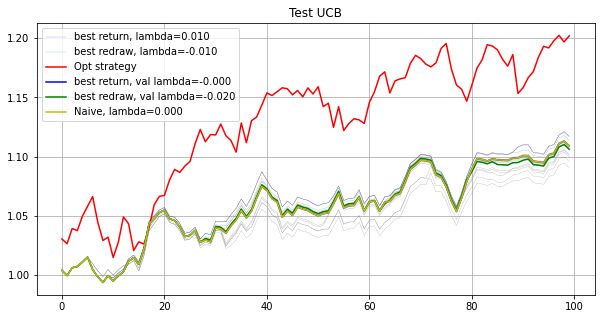

Phase 10
Validating...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.0277 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0256 0.     0.0052 0.     0.
 0.0478 0.     0.     0.0095 0.0026 0.049  0.0191 0.     0.     0.0055
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0662 0.     0.     0.
 0.     0.1579 0.     0.0097 0.0027 0.     0.     0.     0.0202 0.
 0.0133 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0815 0.0563 0.     0.0392 0.     0.126  0.
 0.     0.0112 0.0512 0.     0.     0.     0.     0.     0.     0.
 0.1021 0.     0.     0.     0.     0.0707 0.     0.     0.     0.    ]
0.9942355896417532
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0034 0.0095 0.     0.     0.0245 0.0164 0.0017 0.     0.
 0.     0.     0.     0.0021 0.     0.     0.     0.0066 0.     0.0066
 0.     0.     0.

[0.     0.0029 0.022  0.     0.     0.     0.     0.     0.     0.0004
 0.     0.     0.0129 0.0778 0.     0.0008 0.0073 0.008  0.0085 0.
 0.0971 0.     0.     0.     0.     0.084  0.0034 0.0115 0.     0.0224
 0.     0.0185 0.     0.     0.     0.     0.     0.     0.011  0.
 0.     0.0045 0.     0.0017 0.     0.     0.0014 0.     0.     0.0663
 0.     0.0358 0.     0.     0.     0.0167 0.     0.0207 0.     0.
 0.     0.1474 0.     0.     0.     0.     0.     0.     0.     0.
 0.0075 0.     0.     0.025  0.     0.     0.1157 0.     0.     0.1286
 0.     0.     0.     0.0336 0.     0.     0.     0.     0.     0.
 0.     0.0064 0.     0.     0.     0.     0.     0.     0.     0.    ]
1.0128764854815744
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0226 0.     0.     0.015  0.     0.     0.     0.
 0.     0.0303 0.     0.     0.     0.0679 0.     0.     0.     0.0187
 0.     0.     0.     0.0038 0.     0.     0.     0.0079 0.     0.0435
 0.     0.    

[0.     0.     0.0488 0.0019 0.     0.     0.     0.     0.     0.
 0.     0.     0.0035 0.     0.0868 0.0652 0.     0.     0.     0.
 0.1066 0.0482 0.     0.     0.     0.0074 0.     0.     0.     0.025
 0.     0.     0.0067 0.     0.     0.0341 0.     0.     0.     0.0101
 0.     0.     0.     0.     0.     0.     0.     0.     0.0772 0.
 0.     0.     0.     0.     0.     0.     0.     0.0101 0.     0.
 0.     0.0405 0.     0.0188 0.0092 0.     0.     0.     0.     0.
 0.     0.     0.     0.1659 0.     0.     0.0543 0.     0.     0.
 0.     0.     0.0591 0.0064 0.     0.     0.     0.     0.     0.0061
 0.     0.     0.0451 0.0448 0.     0.     0.     0.     0.0181 0.    ]
0.9764173451264357
[0.     0.0035 0.     0.     0.0962 0.     0.     0.     0.     0.
 0.     0.     0.0352 0.     0.0476 0.0118 0.     0.     0.     0.
 0.1201 0.0396 0.     0.0031 0.     0.     0.     0.0034 0.     0.0282
 0.     0.0169 0.0383 0.     0.0114 0.     0.     0.     0.     0.0175
 0.     0.     0.  

[0.     0.     0.0158 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0594 0.     0.     0.     0.
 0.     0.0384 0.     0.     0.     0.0405 0.     0.0026 0.     0.0016
 0.     0.     0.0287 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0023 0.     0.     0.     0.1277 0.     0.     0.
 0.     0.0199 0.     0.0241 0.     0.0416 0.     0.     0.0221 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1491 0.     0.     0.     0.     0.     0.
 0.     0.     0.0214 0.0553 0.0703 0.     0.     0.     0.     0.
 0.     0.     0.2231 0.     0.     0.     0.     0.     0.0563 0.    ]
0.9987301616002826
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0744 0.     0.     0.     0.
 0.0707 0.0312 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0569 0.     0.     0.     0.1447
 0.     0.     0.     0.     0

[0.     0.0054 0.     0.     0.     0.     0.0138 0.     0.     0.
 0.     0.0062 0.0343 0.     0.0701 0.0089 0.     0.     0.     0.
 0.1237 0.0402 0.     0.0057 0.     0.0641 0.     0.0047 0.     0.0151
 0.     0.1423 0.     0.     0.     0.     0.     0.     0.0131 0.0888
 0.     0.     0.     0.     0.     0.     0.0324 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0116 0.0231 0.
 0.     0.     0.     0.0704 0.     0.     0.     0.     0.0034 0.
 0.     0.     0.     0.     0.0269 0.     0.     0.     0.     0.0253
 0.0875 0.     0.     0.     0.     0.     0.     0.     0.     0.0193
 0.     0.0111 0.     0.     0.     0.     0.     0.0047 0.0478 0.    ]
1.0131670424831314
[0.     0.     0.     0.     0.     0.0007 0.     0.     0.     0.
 0.0017 0.0277 0.0243 0.     0.0298 0.0094 0.     0.0029 0.     0.
 0.     0.0109 0.     0.0055 0.     0.0544 0.     0.     0.     0.0434
 0.     0.     0.0169 0.     0.     0.     0.     0.0491 0.0075 0.0143
 0.     0.    

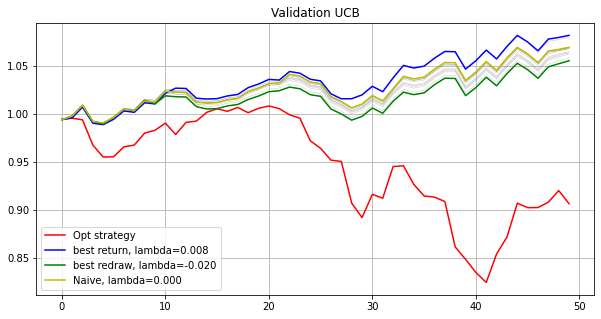

Testing...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.08116028    Max redraw: 0.04229200
lambda: -0.018   Total log return: 0.08348685    Max redraw: 0.04229200
lambda: -0.016   Total log return: 0.06238050    Max redraw: 0.04229200
lambda: -0.014   Total log return: 0.06048604    Max redraw: 0.04229200
lambda: -0.012   Total log return: 0.06024048    Max redraw: 0.04229200
lambda: -0.010   Total log return: 0.05893089    Max redraw: 0.04229200
lambda: -0.008   Total log return: 0.07108065    Max redraw: 0.04229200
lambda: -0.006   Total log return: 0.07304868    Max redraw: 0.04229200
lambda: -0.004   Total log return: 0.07828324    Max redraw: 0.04229200
lambda: -0.002   Total log return: 0.08972199    Max redraw: 0.04229200
lambda: -0.000   Total log return: 0.09715899    Max redraw: 0.04229200
lambda: 0.002   Total log return: 0.09687345    Max redraw: 0.04229200
lambda: 0.004   Total log return: 0.10057098    Max redraw: 0.0422920

[0.     0.     0.0378 0.     0.0034 0.     0.     0.     0.     0.
 0.     0.     0.0015 0.0279 0.     0.0234 0.     0.0037 0.0036 0.
 0.0557 0.0308 0.     0.     0.     0.     0.     0.     0.     0.0136
 0.     0.     0.     0.     0.0044 0.0249 0.     0.     0.     0.0254
 0.     0.     0.0135 0.     0.     0.     0.0682 0.     0.     0.
 0.     0.1456 0.     0.0658 0.     0.     0.     0.003  0.0085 0.
 0.0011 0.0101 0.     0.     0.0224 0.     0.     0.     0.     0.
 0.     0.     0.     0.0969 0.     0.     0.     0.0319 0.0874 0.
 0.     0.     0.0057 0.     0.0552 0.     0.     0.     0.     0.
 0.1286 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
1.0079484265184422
[0.     0.0018 0.     0.     0.     0.     0.0081 0.0021 0.     0.0047
 0.     0.     0.     0.     0.     0.0207 0.     0.0117 0.     0.
 0.1023 0.     0.     0.0085 0.     0.0296 0.0092 0.0074 0.     0.0276
 0.     0.     0.0058 0.     0.     0.0548 0.     0.     0.     0.0149
 0.     0.     0. 

[0.     0.001  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0313 0.     0.     0.0169 0.     0.     0.     0.
 0.     0.0115 0.     0.     0.     0.1255 0.     0.     0.     0.0287
 0.     0.     0.     0.     0.     0.0442 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0182 0.     0.0183 0.     0.0149
 0.     0.0701 0.     0.     0.     0.     0.     0.0078 0.     0.
 0.     0.0256 0.     0.     0.0308 0.     0.     0.     0.     0.1795
 0.     0.     0.     0.0553 0.     0.0163 0.     0.     0.     0.
 0.     0.     0.0627 0.     0.     0.     0.     0.     0.     0.1065
 0.0314 0.     0.0067 0.     0.     0.     0.     0.     0.0745 0.0223]
0.9920747255098625
[0.     0.     0.0409 0.     0.009  0.0069 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0338 0.     0.     0.     0.
 0.     0.0212 0.     0.     0.     0.1056 0.     0.     0.     0.
 0.     0.     0.0252 0.     0.0416 0.     0.     0.     0.     0.
 0.     0.     0.     

[0.     0.     0.0328 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0481 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1035 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0516 0.     0.     0.
 0.     0.     0.     0.0191 0.     0.0884 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.035
 0.     0.     0.     0.1635 0.0556 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1009 0.     0.     0.     0.     0.
 0.1354 0.0154 0.     0.     0.     0.     0.0591 0.0917 0.     0.    ]
0.9811739319568372
[0.     0.     0.     0.     0.0421 0.     0.     0.     0.     0.
 0.     0.0176 0.     0.     0.0409 0.0206 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0063 0.     0.     0.     0.0237
 0.032  0.     0.     0.     0.0492 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.

[0.     0.     0.0051 0.     0.0127 0.0084 0.0159 0.     0.     0.
 0.     0.     0.0116 0.     0.0206 0.0075 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0561 0.     0.     0.     0.0181
 0.     0.     0.0281 0.004  0.     0.     0.     0.     0.     0.0287
 0.     0.     0.     0.     0.     0.     0.0788 0.     0.0513 0.
 0.     0.0457 0.     0.     0.     0.     0.0012 0.     0.     0.
 0.     0.0187 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1141 0.0258 0.     0.     0.     0.     0.0119
 0.     0.     0.     0.     0.0618 0.0225 0.     0.     0.     0.0697
 0.     0.     0.2709 0.     0.     0.     0.     0.0109 0.     0.    ]
0.9877048602677589
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0061 0.     0.0031 0.     0.     0.     0.
 0.     0.     0.     0.     0.0252 0.     0.     0.     0.     0.0148
 0.     0.     0. 

[0.     0.     0.     0.     0.     0.     0.0066 0.     0.     0.
 0.007  0.     0.     0.     0.     0.0231 0.     0.     0.     0.
 0.0732 0.     0.     0.     0.     0.0426 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1528 0.     0.0724 0.
 0.     0.0742 0.     0.     0.0533 0.0343 0.     0.0454 0.0009 0.
 0.0185 0.0411 0.     0.     0.     0.     0.     0.019  0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1346 0.     0.     0.     0.     0.     0.     0.     0.0057
 0.     0.     0.173  0.     0.     0.0224 0.     0.     0.     0.    ]
1.0148644910371023
[0.0112 0.     0.0199 0.     0.0079 0.     0.     0.     0.     0.
 0.     0.0478 0.0038 0.0254 0.     0.     0.     0.     0.     0.
 0.0383 0.     0.     0.     0.     0.0712 0.     0.0017 0.     0.0543
 0.     0.     0.     0.     0.0238 0.     0.     0.     0.01   0.1446
 0.     0.     0.     0.  

[0.     0.0007 0.     0.     0.     0.0075 0.     0.0031 0.     0.0014
 0.0006 0.     0.     0.     0.     0.0146 0.0244 0.     0.0056 0.
 0.     0.0142 0.     0.0216 0.     0.0279 0.0113 0.0014 0.     0.0277
 0.     0.0475 0.     0.     0.     0.     0.     0.0165 0.     0.
 0.     0.     0.     0.     0.0018 0.     0.0563 0.0835 0.0115 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0021 0.0631 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0284 0.     0.     0.     0.002  0.     0.     0.     0.0209
 0.0008 0.     0.     0.     0.0407 0.     0.     0.     0.     0.
 0.1384 0.     0.2665 0.     0.     0.0529 0.     0.005  0.     0.    ]
1.0007617096480776
[0.     0.     0.0086 0.     0.0312 0.     0.     0.     0.     0.
 0.0083 0.0002 0.     0.001  0.     0.0135 0.     0.     0.     0.
 0.11   0.041  0.     0.     0.     0.0512 0.     0.     0.     0.
 0.     0.     0.0201 0.     0.0049 0.0013 0.     0.     0.     0.
 0.     0.     0.     0.  

[0.0098 0.     0.0225 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.01   0.     0.     0.     0.     0.     0.     0.
 0.1156 0.     0.     0.0208 0.     0.071  0.0263 0.     0.     0.
 0.     0.     0.     0.008  0.     0.     0.     0.0839 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0356 0.
 0.     0.     0.     0.0154 0.     0.     0.     0.     0.     0.
 0.     0.031  0.     0.     0.027  0.     0.     0.     0.     0.1767
 0.     0.0487 0.     0.0547 0.     0.     0.0846 0.     0.     0.0411
 0.     0.0089 0.     0.     0.0507 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0576 0.     0.    ]
0.9898895716543997
[0.     0.     0.     0.     0.     0.     0.0129 0.     0.     0.
 0.     0.     0.0327 0.0055 0.     0.     0.0457 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0099 0.     0.     0.     0.     0.0119 0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.     0.     0.     0.     0.     0.0022 0.     0.     0.     0.
 0.     0.0063 0.     0.     0.0348 0.0437 0.     0.     0.     0.
 0.     0.     0.     0.0148 0.     0.0401 0.     0.     0.     0.0022
 0.     0.     0.0273 0.     0.     0.     0.     0.0053 0.0133 0.
 0.     0.     0.     0.     0.     0.0011 0.005  0.     0.0028 0.0213
 0.     0.     0.     0.     0.     0.2016 0.     0.0153 0.     0.
 0.     0.0822 0.     0.0511 0.     0.     0.     0.0381 0.     0.
 0.     0.0226 0.     0.0025 0.     0.     0.     0.0275 0.     0.1726
 0.     0.0018 0.     0.     0.     0.     0.0452 0.     0.     0.0071
 0.1123 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
1.0068290315470327
[0.     0.     0.0184 0.     0.     0.0115 0.0164 0.0001 0.     0.0012
 0.     0.0206 0.0011 0.     0.0212 0.019  0.     0.0126 0.     0.0002
 0.0618 0.0493 0.     0.0025 0.     0.013  0.0231 0.     0.     0.0117
 0.     0.     0.     0.     0.     0.     0.     0.01   0.0045 0.001
 0.    

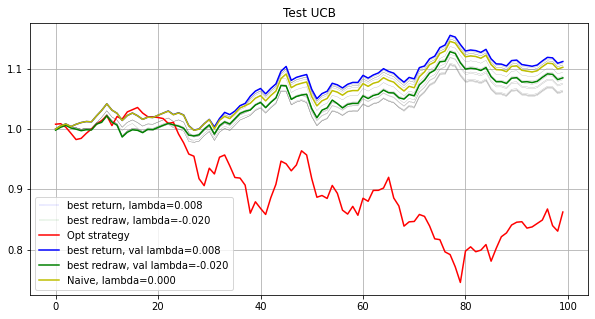

Phase 11
Validating...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
Opt strategy
[0.0566 0.     0.     0.     0.     0.007  0.     0.     0.     0.
 0.     0.0301 0.     0.     0.     0.     0.     0.     0.013  0.
 0.     0.0205 0.     0.0797 0.     0.0017 0.0417 0.     0.     0.
 0.     0.     0.     0.     0.0676 0.0081 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.042  0.     0.
 0.1115 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0236 0.     0.0346 0.     0.0643 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0828 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.2806 0.     0.     0.     0.0345]
0.983184284487639
[0.0552 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0036 0.     0.0092 0.     0.     0.     0.0047 0.     0.     0.
 0.0501 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.  

[0.     0.     0.     0.     0.     0.0489 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.048  0.     0.     0.
 0.0357 0.0627 0.     0.     0.     0.     0.0306 0.     0.     0.
 0.     0.     0.     0.     0.0001 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.091  0.     0.0418 0.     0.
 0.     0.     0.     0.007  0.0195 0.     0.     0.0232 0.     0.
 0.     0.1844 0.0062 0.     0.0227 0.     0.     0.     0.     0.1358
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0133 0.     0.     0.     0.2292 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
1.0052605756604922
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0636 0.     0.     0.
 0.1195 0.     0.     0.     0.     0.0173 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0929 0.     0.035  0.     0.
 0.     0.     0.     0.     0.   

[0.0331 0.     0.     0.     0.     0.0349 0.     0.     0.     0.
 0.0248 0.     0.021  0.     0.     0.     0.0571 0.     0.     0.
 0.0496 0.     0.     0.0173 0.     0.     0.     0.     0.     0.0145
 0.     0.     0.     0.     0.0259 0.     0.0212 0.     0.     0.
 0.     0.     0.0339 0.     0.     0.     0.     0.0063 0.     0.0623
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0317 0.0084 0.     0.     0.0125
 0.     0.     0.     0.     0.     0.     0.     0.0368 0.     0.0303
 0.0095 0.     0.     0.     0.2549 0.0043 0.     0.     0.     0.0284
 0.     0.     0.     0.1812 0.     0.     0.     0.     0.     0.    ]
0.9873334931874292
[0.     0.     0.     0.     0.     0.0343 0.     0.0057 0.     0.
 0.     0.     0.0003 0.     0.     0.     0.     0.     0.     0.
 0.0196 0.     0.     0.033  0.     0.     0.0111 0.     0.     0.
 0.     0.     0.     0.0204 0.0749 0.     0.     0.     0.     0.
 0.     0.     0. 

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0834 0.     0.     0.     0.     0.
 0.1027 0.0203 0.     0.0579 0.     0.     0.0109 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0476 0.0269 0.     0.     0.     0.
 0.     0.     0.0758 0.     0.033  0.     0.     0.0591 0.     0.
 0.     0.0143 0.     0.0344 0.0597 0.103  0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.2643 0.
 0.     0.     0.0068 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
1.003537677255858
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0178 0.     0.     0.     0.     0.     0.1061 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0695
 0.     0.     0.     0.1626 0.     0.     0.02   0.     0.     0.
 0.     0.     0.     0.     0.    

[0.     0.     0.     0.     0.     0.0491 0.     0.     0.     0.
 0.0178 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1522
 0.     0.     0.     0.     0.1265 0.0095 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0512 0.     0.     0.036
 0.0016 0.     0.     0.0242 0.     0.     0.     0.     0.     0.
 0.     0.1525 0.     0.0954 0.1783 0.0298 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0001
 0.     0.     0.     0.     0.     0.     0.0759 0.     0.     0.    ]
0.9922520775986815
[0.0144 0.     0.     0.     0.     0.0028 0.     0.     0.     0.
 0.0604 0.     0.     0.     0.     0.     0.0063 0.0067 0.     0.
 0.043  0.     0.     0.0189 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0479 0.0385 0.     0.     0.     0.
 0.     0.     0.     0.   

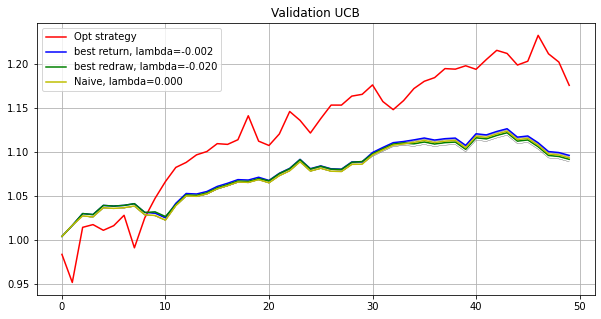

Testing...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.00655404    Max redraw: 0.03963933
lambda: -0.018   Total log return: 0.00334525    Max redraw: 0.04059558
lambda: -0.016   Total log return: 0.00335113    Max redraw: 0.04059558
lambda: -0.014   Total log return: 0.00373069    Max redraw: 0.04059558
lambda: -0.012   Total log return: 0.00750634    Max redraw: 0.04059558
lambda: -0.010   Total log return: 0.00599503    Max redraw: 0.04059558
lambda: -0.008   Total log return: 0.00500325    Max redraw: 0.04059558
lambda: -0.006   Total log return: 0.00408816    Max redraw: 0.04059558
lambda: -0.004   Total log return: 0.00354523    Max redraw: 0.04059558
lambda: -0.002   Total log return: 0.00347971    Max redraw: 0.04059558
lambda: -0.000   Total log return: 0.00521187    Max redraw: 0.04059558
lambda: 0.002   Total log return: 0.00314349    Max redraw: 0.04059558
lambda: 0.004   Total log return: 0.00588208    Max redraw: 0.0408738

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1284 0.     0.     0.
 0.0472 0.     0.     0.0445 0.     0.     0.     0.     0.     0.0076
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0198 0.     0.     0.     0.     0.     0.     0.
 0.     0.0091 0.     0.     0.2307 0.     0.     0.     0.     0.
 0.     0.0241 0.0325 0.     0.     0.0047 0.     0.     0.0534 0.
 0.     0.0494 0.     0.     0.     0.     0.     0.     0.0794 0.0409
 0.     0.1067 0.     0.     0.1216 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
1.0094472264670369
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0022 0.
 0.0597 0.     0.     0.061  0.     0.04   0.     0.     0.     0.
 0.     0.     0.     0.     0.1317 0.057  0.     0.     0.     0.
 0.0011 0.     0.     0.     0

[0.0431 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.2304 0.     0.     0.
 0.     0.     0.     0.0113 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0058 0.     0.     0.     0.
 0.     0.     0.007  0.     0.     0.     0.0048 0.     0.     0.0397
 0.     0.     0.     0.     0.1209 0.     0.     0.0588 0.     0.0321
 0.     0.0454 0.     0.0412 0.0206 0.0329 0.     0.     0.     0.
 0.     0.     0.     0.066  0.0084 0.     0.     0.     0.0264 0.0957
 0.     0.     0.     0.0119 0.     0.     0.     0.     0.     0.0976
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
1.03599001670088
[0.0331 0.     0.     0.     0.     0.0028 0.     0.     0.     0.
 0.     0.071  0.0021 0.     0.     0.0084 0.0481 0.     0.0267 0.0007
 0.0496 0.0158 0.     0.     0.     0.0071 0.     0.     0.     0.0351
 0.     0.     0.     0.     0.1148 0.0187 0.     0.     0.     0.
 0.     0.     0

[0.0745 0.     0.0016 0.     0.     0.0003 0.     0.     0.     0.
 0.     0.     0.0113 0.     0.     0.     0.2035 0.     0.0225 0.
 0.0307 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0066 0.     0.     0.     0.02   0.     0.     0.
 0.     0.     0.0536 0.     0.     0.0082 0.0135 0.0006 0.     0.0721
 0.0071 0.     0.     0.0099 0.1136 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.092  0.     0.     0.0383 0.
 0.     0.0644 0.     0.     0.     0.     0.     0.     0.0283 0.0352
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0712 0.     0.     0.0209 0.     0.     0.     0.    ]
1.017113324780807
[0.     0.     0.     0.     0.     0.0014 0.     0.     0.     0.
 0.     0.0101 0.0147 0.     0.     0.     0.0463 0.     0.     0.0027
 0.     0.0224 0.     0.0025 0.     0.0108 0.     0.     0.     0.
 0.     0.     0.     0.     0.0872 0.0278 0.     0.     0.     0.
 0.     0.     0.     0.   

[0.0722 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1045 0.     0.     0.     0.     0.0032
 0.     0.     0.     0.     0.031  0.1016 0.     0.0007 0.     0.2029
 0.0547 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0517 0.022  0.     0.     0.0246 0.
 0.     0.0768 0.     0.     0.     0.     0.     0.     0.     0.0709
 0.     0.     0.     0.0998 0.     0.0496 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0338]
1.0134934066055585
[0.0857 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0659 0.     0.     0.
 0.     0.0309 0.     0.     0.     0.0083 0.     0.     0.     0.0269
 0.     0.     0.     0.     0.1843 0.     0.     0.     0.     0.
 0.     0.     0.     

[0.113  0.     0.     0.     0.     0.004  0.     0.     0.     0.
 0.     0.     0.0023 0.     0.     0.     0.     0.     0.     0.
 0.0831 0.     0.     0.     0.     0.     0.0858 0.0359 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0611 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0585 0.     0.     0.0339 0.     0.     0.     0.
 0.     0.0808 0.     0.     0.     0.     0.     0.     0.1268 0.
 0.0912 0.     0.     0.     0.     0.     0.     0.     0.     0.166
 0.     0.     0.     0.0382 0.     0.     0.     0.0193 0.     0.    ]
1.0211521337358882
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0013 0.
 0.     0.     0.     0.0497 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0503
 0.     0.     0.     0.     0.

[0.     0.     0.0005 0.     0.     0.0182 0.     0.0057 0.     0.
 0.     0.0066 0.     0.     0.     0.     0.0511 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0021 0.
 0.     0.     0.     0.     0.0901 0.0023 0.     0.     0.0047 0.
 0.     0.     0.     0.     0.     0.     0.     0.0275 0.     0.0021
 0.     0.     0.0342 0.0078 0.     0.     0.     0.0733 0.     0.0397
 0.     0.     0.     0.     0.     0.0643 0.0644 0.     0.     0.
 0.     0.0175 0.     0.0357 0.     0.     0.     0.1025 0.     0.
 0.     0.     0.     0.0432 0.     0.0111 0.     0.     0.     0.
 0.     0.     0.     0.2954 0.     0.     0.     0.     0.     0.    ]
1.0071219230840878
[0.045  0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0823 0.     0.     0.0194 0.     0.     0.0388 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0314
 0.     0.     0.     0.  

[0.1141 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0564 0.     0.     0.0728 0.     0.     0.
 0.     0.     0.     0.     0.0756 0.     0.0674 0.     0.     0.
 0.     0.     0.0138 0.     0.     0.     0.1046 0.0901 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.028  0.     0.     0.     0.
 0.     0.1081 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1338 0.     0.     0.     0.     0.0207 0.
 0.     0.     0.1065 0.     0.     0.0081 0.     0.     0.     0.    ]
1.0129026190616832
[0.0252 0.     0.     0.     0.     0.0259 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0122 0.     0.     0.0122
 0.     0.     0.     0.     0.     0.     0.1466 0.     0.     0.
 0.     0.     0.     0.     0.049

[0.0341 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0002 0.     0.     0.     0.0535 0.     0.0001 0.
 0.     0.0231 0.0018 0.     0.     0.004  0.0317 0.     0.     0.0125
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0153 0.     0.0465 0.     0.0476 0.0031 0.     0.1621
 0.0073 0.     0.     0.     0.     0.     0.     0.0963 0.     0.
 0.     0.0174 0.     0.     0.     0.0225 0.     0.     0.     0.
 0.     0.0146 0.     0.     0.     0.     0.     0.011  0.     0.0064
 0.0731 0.     0.     0.0304 0.     0.     0.     0.     0.     0.0012
 0.     0.     0.     0.2282 0.     0.0561 0.     0.     0.     0.    ]
0.9931472896693785
[0.0454 0.     0.0079 0.     0.     0.0013 0.     0.     0.     0.
 0.     0.     0.0202 0.     0.     0.     0.     0.     0.     0.
 0.0165 0.0113 0.0019 0.0266 0.     0.     0.     0.     0.0064 0.
 0.     0.     0.     0.     0.0989 0.0523 0.     0.     0.     0.
 0.     0.     0.     

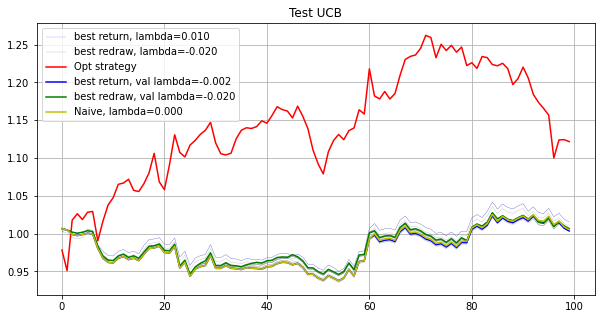

-----------------------------Final result-----------------------------
Opt strategy
Total return: 1.72875089
Mean return: 1.00068448
best return strategy
Total return: 1.91440952
Mean return: 1.00081209
best redraw strategy
Total return: 1.86537551
Mean return: 1.00077963
Naive strategy
Total return: 1.92961887
Mean return: 1.00082199


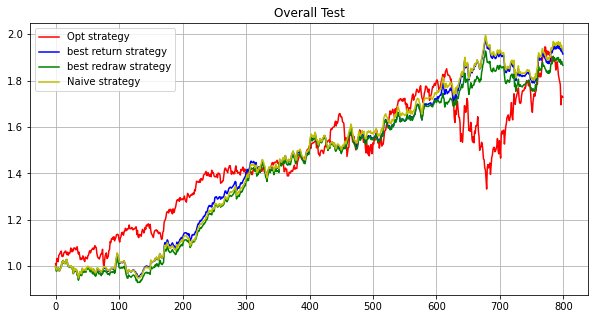

In [10]:
opt_lst=run(path, maxiter, subn, lb, testv=np.arange(-0.02, 0.0100001, 0.002), delta=delta)

Phase 4
Validating...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0405561992513026
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9995198079489647
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9910114028833638
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9903234030552459
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0035103115875246
[0. 0. 0. 0. 0. 0. 0. 0. 

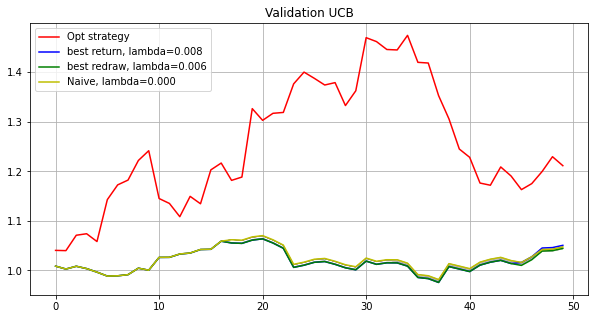

Testing...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.01449593    Max redraw: 0.04741015
lambda: -0.018   Total log return: 0.01716019    Max redraw: 0.04741015
lambda: -0.016   Total log return: 0.02061541    Max redraw: 0.04741015
lambda: -0.014   Total log return: 0.02000184    Max redraw: 0.04741015
lambda: -0.012   Total log return: 0.01634502    Max redraw: 0.04741015
lambda: -0.010   Total log return: 0.01472589    Max redraw: 0.04741015
lambda: -0.008   Total log return: 0.01082606    Max redraw: 0.04741015
lambda: -0.006   Total log return: 0.01604362    Max redraw: 0.04741015
lambda: -0.004   Total log return: 0.02503168    Max redraw: 0.04741015
lambda: -0.002   Total log return: 0.03747112    Max redraw: 0.04741015
lambda: -0.000   Total log return: 0.03954515    Max redraw: 0.04741015
lambda: 0.002   Total log return: 0.04020998    Max redraw: 0.04741015
lambda: 0.004   Total log return: 0.03820739    Max redraw: 0.0474101

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0415511946568414
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9932164702915396
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9615898470408762
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0274897042506848
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9879691447457173
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9683867995450394
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.010953296073741
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0402547754801452
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.97842056666685
[0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.995208070831452
Opt strategy   Total log return: 0.15244916    Max redraw: 0.04741015
Total return: 1.16468325
Mean return: 1.00152565
best return val lambda: 0.002   Total log return: 0.03431735
Total return: 1.03491299
Mean return: 1.00034323
best redraw val lambda: 0.006   Total log return: 0.01449593
Total return: 1.01460151
Mean return: 1.00014497
Naive lambda: 0.000   Total log return: 0.03954515
Total return: 1.04033747
Mean return: 1.00039553


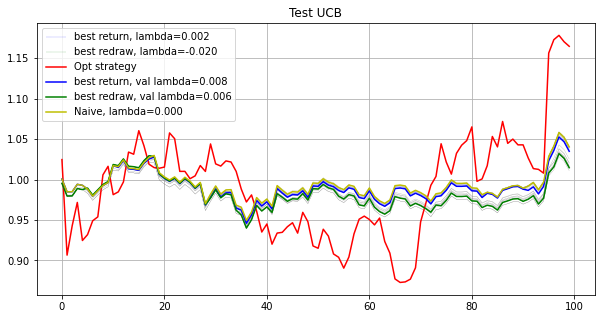

Phase 5
Validating...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9850215792400584
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9935897423158924
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.027112674626998
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0262125297041707
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0051648793106127
[0. 0. 0. 0. 0. 0. 0. 0. 0

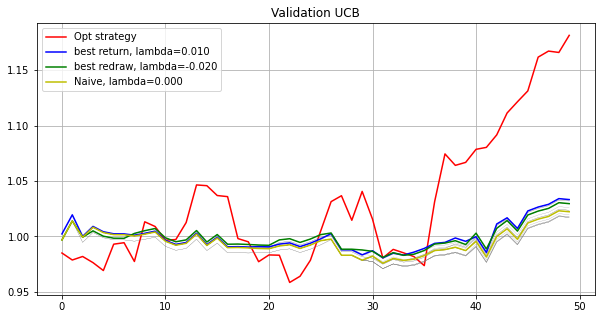

Testing...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09457053    Max redraw: 0.05127117
lambda: -0.018   Total log return: 0.09657663    Max redraw: 0.05127117
lambda: -0.016   Total log return: 0.07670235    Max redraw: 0.05127117
lambda: -0.014   Total log return: 0.06304404    Max redraw: 0.05127117
lambda: -0.012   Total log return: 0.06297960    Max redraw: 0.05127117
lambda: -0.010   Total log return: 0.07044942    Max redraw: 0.05127117
lambda: -0.008   Total log return: 0.07622245    Max redraw: 0.05127117
lambda: -0.006   Total log return: 0.07791816    Max redraw: 0.05127117
lambda: -0.004   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.002   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.000   Total log return: 0.06776157    Max redraw: 0.05129385
lambda: 0.002   Total log return: 0.07697366    Max redraw: 0.05129385
lambda: 0.004   Total log return: 0.07856000    Max redraw: 0.0497349

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9882401489990552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9896620097388701
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0311192457449878
[0. 0. 0. 0. 0. 0. 0. 0. 

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9779411930318535
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9950884081199773
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0000000004857124
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9866290481919537
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0229390673991117
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0050287432456717
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.996678855249505
Opt strategy   Total log return: 0.07951700    Max redraw: 0.04950321
Total return: 1.08276396
Mean return: 1.00079549
best return val lambda: -0.018   Total log return: 0.08253240
Total return: 1.08603386
Mean return: 1.00082566
best redraw val lambda: -0.020   Total log return: 0.07526718
Total return: 1.07817218
Mean return: 1.00075296
Naive lambda: 0.000   Total log return: 0.06776157
Total return: 1.07011013
Mean return: 1.00067785


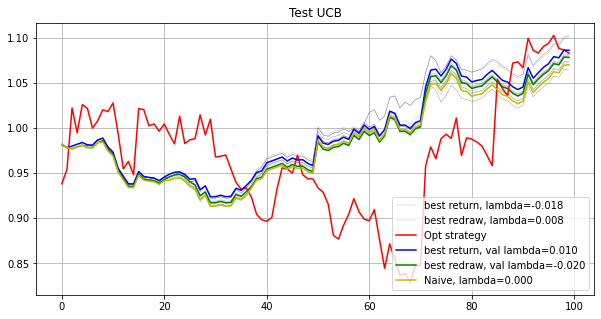

Phase 6
Validating...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9977842168233851
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9947473736299887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9884498480270671
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0100780673449223
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9886990081070414
[0. 0. 0. 0. 0. 0. 0. 0. 

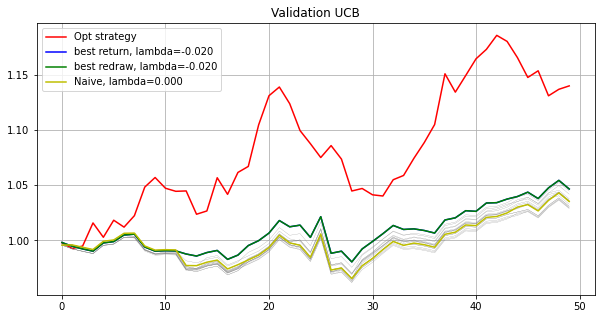

Testing...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.20825661    Max redraw: 0.04421898
lambda: -0.018   Total log return: 0.20924816    Max redraw: 0.04421898
lambda: -0.016   Total log return: 0.21651083    Max redraw: 0.04421898
lambda: -0.014   Total log return: 0.21232723    Max redraw: 0.04421898
lambda: -0.012   Total log return: 0.21022755    Max redraw: 0.04421898
lambda: -0.010   Total log return: 0.20631076    Max redraw: 0.04421898
lambda: -0.008   Total log return: 0.20639946    Max redraw: 0.04421898
lambda: -0.006   Total log return: 0.20400683    Max redraw: 0.04421898
lambda: -0.004   Total log return: 0.19399370    Max redraw: 0.04421898
lambda: -0.002   Total log return: 0.20301120    Max redraw: 0.04421898
lambda: -0.000   Total log return: 0.20169129    Max redraw: 0.04421898
lambda: 0.002   Total log return: 0.19245404    Max redraw: 0.04421898
lambda: 0.004   Total log return: 0.18825244    Max redraw: 0.0442189

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.006537591741267
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.1396896277661672
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0288258727399566
[0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0106824873302989
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0139880924188562
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9861160563782547
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9970926982932509
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0090293422494372
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9905852462007733
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9967132299602265
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0119595162064337
Opt strategy   Total log return: 0.11182117    Max redraw: 0.04421898
Total return: 1.11831285
Mean return: 1.00111884
best return val lambda: -0.016   Total log return: 0.20825661
Total return: 1.23152915
Mean return: 1.00208474
best redraw val lambda: -0.020   Total log return: 0.20825661
Total return: 1.23152915
Mean return: 1.00208474
Naive lam

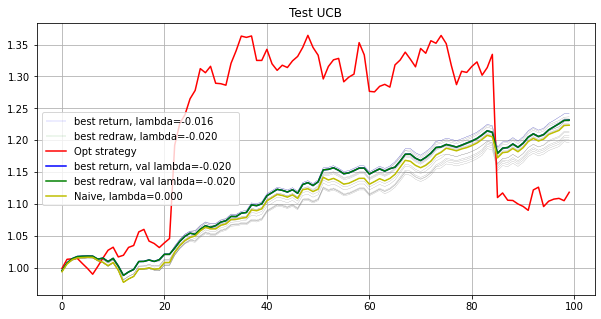

Phase 7
Validating...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9818631467048985
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9465413473813991
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0040113870916936
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9995159729709708
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9713330906926324
[0. 0. 0. 0. 0. 0. 0. 0. 

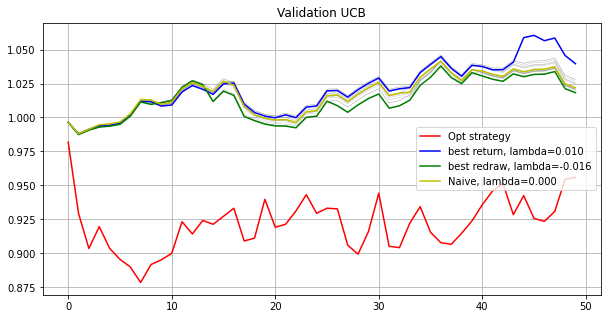

Testing...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09307256    Max redraw: 0.04027295
lambda: -0.018   Total log return: 0.09204683    Max redraw: 0.04117268
lambda: -0.016   Total log return: 0.09059912    Max redraw: 0.04117268
lambda: -0.014   Total log return: 0.09027487    Max redraw: 0.04117268
lambda: -0.012   Total log return: 0.09337694    Max redraw: 0.04117268
lambda: -0.010   Total log return: 0.09945863    Max redraw: 0.04027295
lambda: -0.008   Total log return: 0.10300035    Max redraw: 0.04027295
lambda: -0.006   Total log return: 0.10895820    Max redraw: 0.04027295
lambda: -0.004   Total log return: 0.10850160    Max redraw: 0.04027295
lambda: -0.002   Total log return: 0.10397950    Max redraw: 0.04027295
lambda: -0.000   Total log return: 0.09492290    Max redraw: 0.03980353
lambda: 0.002   Total log return: 0.09419810    Max redraw: 0.03980353
lambda: 0.004   Total log return: 0.07958077    Max redraw: 0.0398035

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9990733589601823
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9898876584745896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.000000000811836
[0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0045586414290728
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9929868003172442
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9805911682872032
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0030895921756788
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.017499513217223
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9937802850709145
[0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9994471175574263
Opt strategy   Total log return: 0.37143087    Max redraw: 0.03980353
Total return: 1.44980762
Mean return: 1.00372122
best return val lambda: -0.006   Total log return: 0.07058874
Total return: 1.07313979
Mean return: 1.00070614
best redraw val lambda: -0.016   Total log return: 0.09492290
Total return: 1.09957407
Mean return: 1.00094968
Naive lambda: 0.000   Total log return: 0.09492290
Total return: 1.09957407
Mean return: 1.00094968


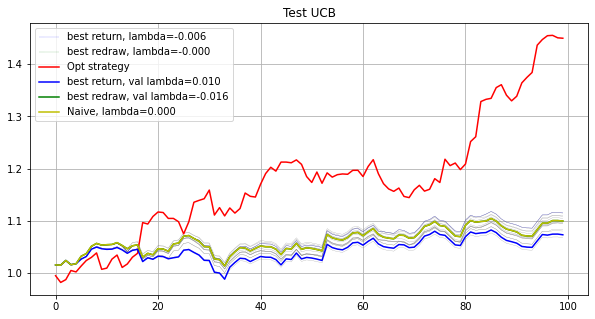

Phase 8
Validating...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0346889942132262
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9929278242214444
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9896808266064079
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
0.9919876740746493
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
0.9951173337881742
[0. 0. 0. 0. 0. 0. 0. 0. 

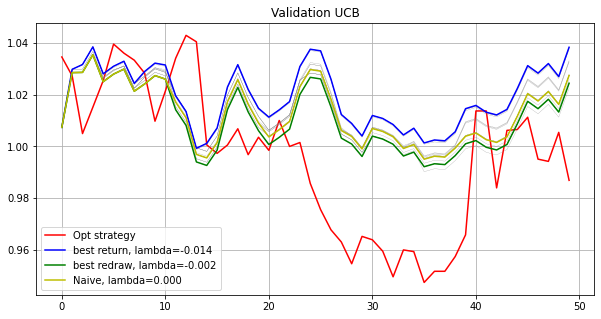

Testing...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.018   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.016   Total log return: 0.04548496    Max redraw: 0.04154353
lambda: -0.014   Total log return: 0.04087616    Max redraw: 0.04154353
lambda: -0.012   Total log return: 0.03717725    Max redraw: 0.04154353
lambda: -0.010   Total log return: 0.04226571    Max redraw: 0.04154353
lambda: -0.008   Total log return: 0.04410808    Max redraw: 0.04154353
lambda: -0.006   Total log return: 0.04088311    Max redraw: 0.04154353
lambda: -0.004   Total log return: 0.04586607    Max redraw: 0.04154353
lambda: -0.002   Total log return: 0.04682497    Max redraw: 0.04154353
lambda: -0.000   Total log return: 0.04745435    Max redraw: 0.04154353
lambda: 0.002   Total log return: 0.04386840    Max redraw: 0.04154353
lambda: 0.004   Total log return: 0.05685098    Max redraw: 0.0415435

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9755816392984445
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0023407770893646
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.023363502237937
[0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0223372841849034
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9963370103982592
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9928760991478931
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9595454596195
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0147949488044845
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9785067885596545
[0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9905049635310059
Opt strategy   Total log return: -0.18679427    Max redraw: 0.04306732
Total return: 0.82961439
Mean return: 0.99813380
best return val lambda: 0.008   Total log return: 0.04087616
Total return: 1.04172309
Mean return: 1.00040885
best redraw val lambda: -0.002   Total log return: 0.04178553
Total return: 1.04267083
Mean return: 1.00041794
Naive lambda: 0.000   Total log return: 0.04745435
Total return: 1.04859833
Mean return: 1.00047466


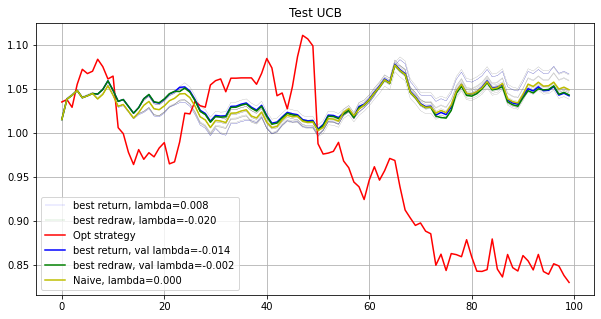

Phase 9
Validating...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.016077170490466
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0000000001479945
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0179885497666405
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0147655028593512
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0180222906406666
[0. 0. 0. 0. 0. 0. 0. 0. 

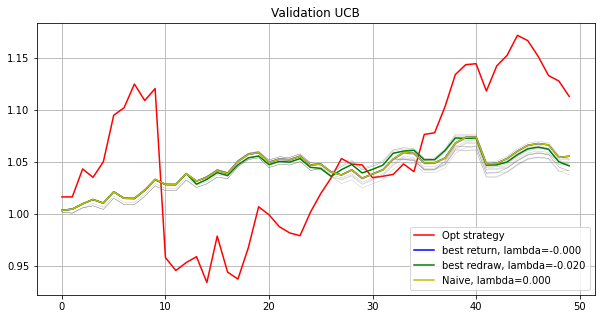

Testing...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09169513    Max redraw: 0.03340976
lambda: -0.018   Total log return: 0.09705971    Max redraw: 0.03340976
lambda: -0.016   Total log return: 0.08685545    Max redraw: 0.03340976
lambda: -0.014   Total log return: 0.09649924    Max redraw: 0.03340976
lambda: -0.012   Total log return: 0.09522997    Max redraw: 0.03340976
lambda: -0.010   Total log return: 0.10101991    Max redraw: 0.03267943
lambda: -0.008   Total log return: 0.10152567    Max redraw: 0.03267943
lambda: -0.006   Total log return: 0.10408528    Max redraw: 0.03267943
lambda: -0.004   Total log return: 0.10237535    Max redraw: 0.03267943
lambda: -0.002   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: -0.000   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: 0.002   Total log return: 0.10785830    Max redraw: 0.03267943
lambda: 0.004   Total log return: 0.10442110    Max redraw: 0.0326794

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.009262833523571
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.024889100111608
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0152329747656166
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9881336049607269
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0021715539286153
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9881543247708273
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9943995022053045
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9907720123537231
[0. 0. 0. 1. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9793689321935741
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9988925872827259
Opt strategy   Total log return: 0.25812959    Max redraw: 0.03267943
Total return: 1.29450656
Mean return: 1.00258463
best return val lambda: 0.010   Total log return: 0.10357638
Total return: 1.10913051
Mean return: 1.00103630
best redraw val lambda: -0.020   Total log return: 0.10101991
Total return: 1.10629867
Mean return: 1.00101071
Naive lamb

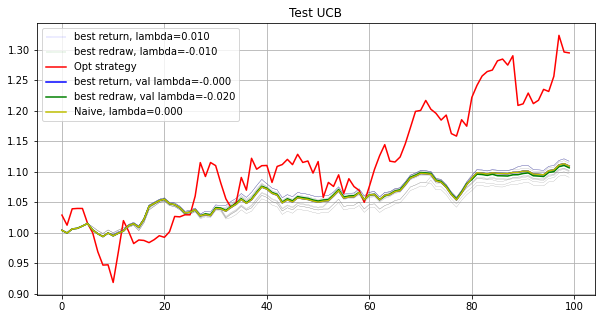

Phase 10
Validating...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.980659698489494
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9925469881734343
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.973587675930743
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9710005384918127
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.002464065268553
[0. 0. 0. 0. 0. 0. 0. 0. 0.

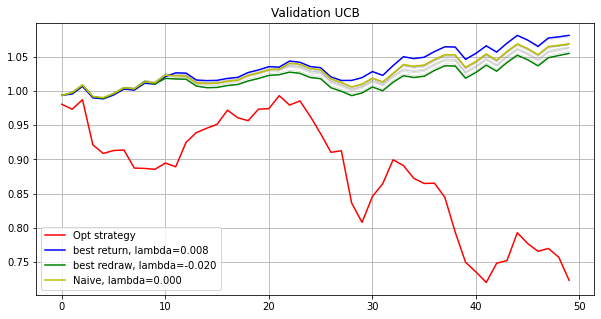

Testing...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.08116028    Max redraw: 0.04229200
lambda: -0.018   Total log return: 0.08348685    Max redraw: 0.04229200
lambda: -0.016   Total log return: 0.06238050    Max redraw: 0.04229200
lambda: -0.014   Total log return: 0.06048604    Max redraw: 0.04229200
lambda: -0.012   Total log return: 0.06024048    Max redraw: 0.04229200
lambda: -0.010   Total log return: 0.05893089    Max redraw: 0.04229200
lambda: -0.008   Total log return: 0.07108065    Max redraw: 0.04229200
lambda: -0.006   Total log return: 0.07304868    Max redraw: 0.04229200
lambda: -0.004   Total log return: 0.07828324    Max redraw: 0.04229200
lambda: -0.002   Total log return: 0.08972199    Max redraw: 0.04229200
lambda: -0.000   Total log return: 0.09715899    Max redraw: 0.04229200
lambda: 0.002   Total log return: 0.09687345    Max redraw: 0.04229200
lambda: 0.004   Total log return: 0.10057098    Max redraw: 0.0422920

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9943154041916438
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9900470116208144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9975808785281395
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0241515370418444
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.019178082216192
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9905771495357232
[0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9704704729243374
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9963137883182132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.970226862729983
[0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.01300748928923
Opt strategy   Total log return: -0.13746439    Max redraw: 0.04229200
Total return: 0.87156538
Mean return: 0.99862630
best return val lambda: 0.008   Total log return: 0.10578188
Total return: 1.11157940
Mean return: 1.00105838
best redraw val lambda: -0.020   Total log return: 0.08116028
Total return: 1.08454471
Mean return: 1.00081193
Naive lambda: 0.000   Total log return: 0.09715899
Total return: 1.10203558
Mean return: 1.00097206


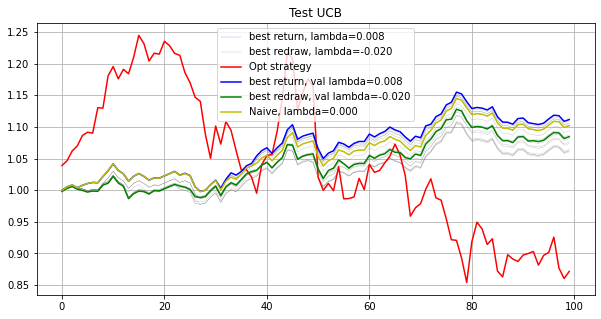

Phase 11
Validating...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
Opt strategy
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
0.974495217859819
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9573493685137136
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0016343770805933
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0462915779465665
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.980116491284339
[0. 0. 0. 0. 0. 0. 0. 0. 0

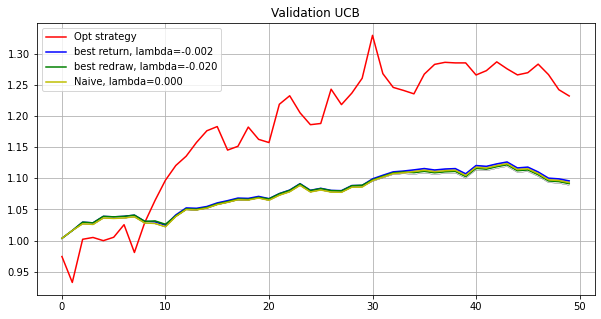

Testing...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.00655404    Max redraw: 0.03963933
lambda: -0.018   Total log return: 0.00334525    Max redraw: 0.04059558
lambda: -0.016   Total log return: 0.00335113    Max redraw: 0.04059558
lambda: -0.014   Total log return: 0.00373069    Max redraw: 0.04059558
lambda: -0.012   Total log return: 0.00750634    Max redraw: 0.04059558
lambda: -0.010   Total log return: 0.00599503    Max redraw: 0.04059558
lambda: -0.008   Total log return: 0.00500325    Max redraw: 0.04059558
lambda: -0.006   Total log return: 0.00408816    Max redraw: 0.04059558
lambda: -0.004   Total log return: 0.00354523    Max redraw: 0.04059558
lambda: -0.002   Total log return: 0.00347971    Max redraw: 0.04059558
lambda: -0.000   Total log return: 0.00521187    Max redraw: 0.04059558
lambda: 0.002   Total log return: 0.00314349    Max redraw: 0.04059558
lambda: 0.004   Total log return: 0.00588208    Max redraw: 0.0408738

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9948778568790692
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0647717926601863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9806866956617741
[0. 0. 0. 0. 0. 0. 0. 0. 

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9869087838063006
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0044759416181415
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9768467478051911
[1. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9724941725677977
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.021976843625614
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.9869238389478819
[1. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1.0022393629963275
Opt strategy   Total log return: 0.29694521    Max redraw: 0.04059558
Total return: 1.34574157
Mean return: 1.00297387
best return val lambda: 0.010   Total log return: 0.00347971
Total return: 1.00348577
Mean return: 1.00003480
best redraw val lambda: -0.020   Total log return: 0.00655404
Total return: 1.00657556
Mean return: 1.00006554
Naive lambda: 0.000   Total log return: 0.00521187
Total return: 1.00522548
Mean return: 1.00005212


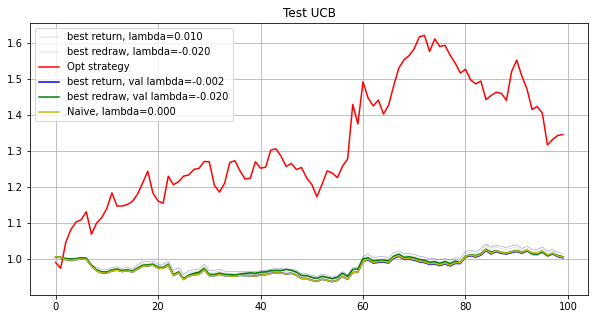

-----------------------------Final result-----------------------------
Opt strategy
Total return: 2.57547591
Mean return: 1.00118324
best return strategy
Total return: 1.91440952
Mean return: 1.00081209
best redraw strategy
Total return: 1.86537551
Mean return: 1.00077963
Naive strategy
Total return: 1.92961887
Mean return: 1.00082199


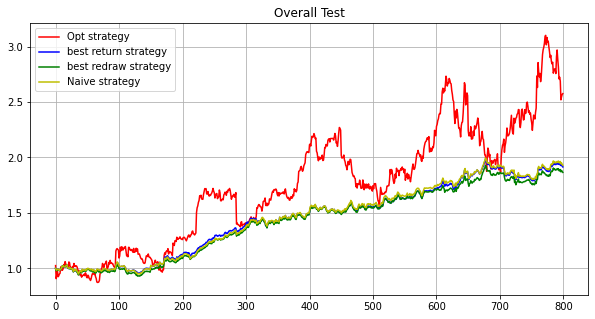

[0.024332099295585784,
 -0.12245705770419026,
 0.03923720278532424,
 0.03014685265693214,
 -0.049631321015291614,
 0.00783334754528708,
 0.01818231689239981,
 0.005096480725294091,
 0.05297467410474713,
 0.010479650750226303,
 -0.035091317957403084,
 0.0035112395102056453,
 0.012406291791827508,
 0.036320461042984226,
 -0.0025510214757221246,
 0.027845598411004882,
 -0.017665455152125014,
 -0.022282265283203862,
 -0.00407936639028225,
 -0.0007709062013837757,
 0.0014503271063615534,
 0.04071113524616064,
 -0.006806642429300285,
 -0.03916727365868523,
 1.1977703423969796e-08,
 -0.009029236039048932,
 0.0035520702405439342,
 0.012583960367336324,
 -0.0071695809094837,
 0.03305844173984976,
 -0.023879983313412918,
 -0.0026538180826350434,
 0.006261574281322685,
 -0.0013440816616684442,
 -0.01140059266716096,
 -0.021912681739680192,
 -0.01625317858033335,
 0.008916036703489031,
 -0.020776134357970984,
 -0.027071591741590562,
 0.010563478063642795,
 -0.026770237414063043,
 0.014810711166043

In [11]:
run(path, maxiter, subn, lb, testv=np.arange(-0.02, 0.0100001, 0.002), delta=5)